In [ ]:
import zipfile
import os

# Yüklediğiniz dosyanın adı. Eğer 'archive.zip' değilse, lütfen düzeltin.
ZIP_PATH = '/content/archive.zip'

# Verilerin çıkarılacağı klasör
EXTRACT_DIR = '/content/cifake_data'

# Klasör yoksa oluşturalım
if not os.path.exists(EXTRACT_DIR):
    os.makedirs(EXTRACT_DIR)

# Zip dosyasını açma
try:
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_DIR)
    print(f"Dosyalar başarıyla '{EXTRACT_DIR}' klasörüne çıkarıldı.")

    # Çıkarılan dosyaları listeleyelim (kontrol amaçlı)
    print("\nÇıkarılan ana klasörler:")
    print(os.listdir(EXTRACT_DIR))

except FileNotFoundError:
    print(f"HATA: '{ZIP_PATH}' dosyası bulunamadı.")
    print("Lütfen Colab'a 'archive.zip' dosyasını yüklediğinizden emin olun.")
except Exception as e:
    print(f"Bir hata oluştu: {e}")

Dosyalar başarıyla '/content/cifake_data' klasörüne çıkarıldı.

Çıkarılan ana klasörler:
['train', 'test']


In [ ]:
import pandas as pd
import glob
import os

# 1. Adım'da tanımladığımız klasör.
EXTRACT_DIR = '/content/cifake_data'

# 1. Adım'daki çıktınıza göre ('test', 'train') bu yol doğrudur
BASE_DATA_PATH = os.path.join(EXTRACT_DIR, 'train')

print(f"Veri yolu olarak '{BASE_DATA_PATH}' kullanılıyor...")

# --- DÜZELTME (BÜYÜK HARF + .jpg uzantısı) ---
# '*.png' -> '*.jpg' olarak güncellendi
real_images = glob.glob(os.path.join(BASE_DATA_PATH, 'REAL', '*.jpg'))
fake_images = glob.glob(os.path.join(BASE_DATA_PATH, 'FAKE', '*.jpg'))
# ----------------------------------------

if not real_images and not fake_images:
    print(f"HATA: '{BASE_DATA_PATH}' içinde 'REAL' veya 'FAKE' klasörlerinde '*.jpg' uzantılı dosya bulunamadı.")
    print("Bu çok beklenmedik bir durum, lütfen klasörleri tekrar kontrol edin.")
else:
    # Etiketleri oluşturma (real=0, fake=1)
    real_labels = [0] * len(real_images)
    fake_labels = [1] * len(fake_images)

    # Bir DataFrame'de birleştirme
    all_files = real_images + fake_images
    all_labels = real_labels + fake_labels

    df = pd.DataFrame({
        'filepath': all_files,
        'label': all_labels
    })

    print(f"\nToplam görüntü sayısı: {len(df)}")
    print("Sınıf dağılımı (Orijinal):")
    # Sınıfların (0 ve 1) ne kadar olduğunu göster
    print(df['label'].value_counts())

Veri yolu olarak '/content/cifake_data/train' kullanılıyor...

Toplam görüntü sayısı: 100000
Sınıf dağılımı (Orijinal):
label
0    50000
1    50000
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split

# Bu hücrenin çalışması için 2. Adım'daki 'df' değişkeninin dolu olması gerekir.
if 'df' not in locals() or df.empty:
    print("HATA: 'df' DataFrame'i bulunamadı veya boş.")
    print("Lütfen 2. Adım'daki kod hücresini başarıyla çalıştırdığınızdan emin olun.")
else:
    # random_state=42: Deneylerin tekrarlanabilir olması için (şablonumuz için önemlidir)
    # stratify=df['label']: Sınıf dağılımını korumak için (0 ve 1 oranları korunur)

    # === BÖLÜMLEME 1: %20 KİLİTLİ NİHAİ TEST SETİ ===
    # Orijinal verinin %80'i 'ana_egitim_df'ye, %20'si 'kilitli_test_df'ye ayrılır.
    ana_egitim_df, kilitli_test_df = train_test_split(
        df,
        test_size=0.20,  # Orijinal 100K veriden %20'si (20K)
        random_state=42,
        stratify=df['label'] # SINIF DAĞILIMINI KORU
    )

    print(f"--- Bölümleme 1 Sonucu ---")
    print(f"Ana Eğitim Seti (Kalan %80) Boyutu: {len(ana_egitim_df)}")
    print(f"KİLİTLİ TEST SETİ (%20) Boyutu: {len(kilitli_test_df)}")
    print("Kilitli Test Seti Dağılımı:")
    # normalize=True oranı gösterir (örn: %50 real, %50 fake)
    print(kilitli_test_df['label'].value_counts(normalize=True))


    # === BÖLÜMLEME 2: COLAB İÇİN EĞİTİM ALT KÜMESİ ===
    # Kalan 'ana_egitim_df' (80K veri) içinden HIZLI DENEYLER için 20K'lık bir alt küme seçelim.
    egitim_alt_kume_df, _ = train_test_split(
        ana_egitim_df,
        train_size=20000, # Mutlak sayı olarak 20.000 adet veri seçiyoruz
        random_state=42,
        stratify=ana_egitim_df['label'] # SINIF DAĞILIMINI KORU
    )

    print(f"\n--- Bölümleme 2 Sonucu ---")
    print(f"COLAB EĞİTİM/VALİDASYON ALT KÜMESİ Boyutu: {len(egitim_alt_kume_df)}")
    print("Eğitim Alt Kümesi Dağılımı:")
    print(egitim_alt_kume_df['label'].value_counts(normalize=True))

    print("\n\n--- HAZIR ---")
    print("Artık ViT modelini 'egitim_alt_kume_df' ile eğitebilirsiniz.")
    print("'kilitli_test_df'yi en son kullanmak üzere saklayın.")

HATA: 'df' DataFrame'i bulunamadı veya boş.
Lütfen 2. Adım'daki kod hücresini başarıyla çalıştırdığınızdan emin olun.


In [ ]:
# Colab'da T4 GPU'yu aldığımızdan emin olalım
# Bu komutun çıktısında 'Tesla T4' veya benzeri bir GPU adı görmelisiniz
print("--- GPU Kontrolü ---")
!nvidia-smi

# Gerekli Hugging Face kütüphanelerini kuruyoruz
print("\n--- Kütüphaneler Kuruluyor ---")
!pip install -q transformers datasets evaluate accelerate
# 'accelerate' kütüphanesi, ViT'nin GPU'da daha verimli eğitilmesini sağlar

print("\nKurulum tamamlandı.")

--- GPU Kontrolü ---
Tue Nov 18 18:01:09 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+--------------------------

In [ ]:
import zipfile
import os

# ZIP dosyası ve çıkartılacak klasör
ZIP_PATH = '/content/archive.zip'
EXTRACT_DIR = '/content/cifake_data'

if not os.path.exists(EXTRACT_DIR):
    os.makedirs(EXTRACT_DIR)

# Zip dosyasını aç
try:
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_DIR)
    print(f"Dosyalar başarıyla '{EXTRACT_DIR}' klasörüne çıkarıldı.")
    print("\nÇıkarılan ana klasörler:")
    print(os.listdir(EXTRACT_DIR))
except FileNotFoundError:
    print(f"HATA: '{ZIP_PATH}' bulunamadı.")
except Exception as e:
    print(f"Bir hata oluştu: {e}")


Dosyalar başarıyla '/content/cifake_data' klasörüne çıkarıldı.

Çıkarılan ana klasörler:
['test', 'train']


In [ ]:
import pandas as pd
import glob

BASE_DATA_PATH = os.path.join(EXTRACT_DIR, 'train')
print(f"Veri yolu olarak '{BASE_DATA_PATH}' kullanılıyor...")

# Görselleri bul
real_images = glob.glob(os.path.join(BASE_DATA_PATH, 'REAL', '*.jpg'))
fake_images = glob.glob(os.path.join(BASE_DATA_PATH, 'FAKE', '*.jpg'))

real_labels = [0]*len(real_images)
fake_labels = [1]*len(fake_images)

df = pd.DataFrame({
    'filepath': real_images + fake_images,
    'label': real_labels + fake_labels
})

print(f"\nToplam görüntü sayısı: {len(df)}")
print("Sınıf dağılımı (Orijinal):")
print(df['label'].value_counts())


Veri yolu olarak '/content/cifake_data/train' kullanılıyor...

Toplam görüntü sayısı: 100000
Sınıf dağılımı (Orijinal):
label
0    50000
1    50000
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split

# %20 kilitli test, %80 ana eğitim
ana_egitim_df, kilitli_test_df = train_test_split(
    df, test_size=0.20, random_state=42, stratify=df['label']
)

# Colab için hızlı eğitim alt kümesi (20K)
egitim_alt_kume_df, _ = train_test_split(
    ana_egitim_df, train_size=20000, random_state=42, stratify=ana_egitim_df['label']
)

print(f"--- Bölümleme 1 ---\nAna Eğitim Seti: {len(ana_egitim_df)}\nKilitli Test Seti: {len(kilitli_test_df)}")
print(kilitli_test_df['label'].value_counts(normalize=True))
print(f"\n--- Bölümleme 2 ---\nEğitim Alt Kümesi: {len(egitim_alt_kume_df)}")
print(egitim_alt_kume_df['label'].value_counts(normalize=True))


--- Bölümleme 1 ---
Ana Eğitim Seti: 80000
Kilitli Test Seti: 20000
label
1    0.5
0    0.5
Name: proportion, dtype: float64

--- Bölümleme 2 ---
Eğitim Alt Kümesi: 20000
label
0    0.5
1    0.5
Name: proportion, dtype: float64


In [ ]:
# GPU kontrol
print("--- GPU Kontrolü ---")
!nvidia-smi

# Gerekli kütüphaneler
print("\n--- Kütüphaneler Kuruluyor ---")
!pip install -q tensorflow matplotlib seaborn scikit-learn opencv-python

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import EfficientNetB0, ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Concatenate, Input
from tensorflow.keras.models import Model
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import random

print("\nKurulum tamamlandı.")


--- GPU Kontrolü ---
Wed Nov 12 18:24:21 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+--------------------------

In [ ]:
import zipfile
import os
import pandas as pd
import glob
from sklearn.model_selection import train_test_split

# Zip dosyası yolu
ZIP_PATH = '/content/archive.zip'
EXTRACT_DIR = '/content/cifake_data'

# Klasör yoksa oluştur
if not os.path.exists(EXTRACT_DIR):
    os.makedirs(EXTRACT_DIR)

# Zip'i aç
with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall(EXTRACT_DIR)
print(f"Dosyalar başarıyla '{EXTRACT_DIR}' klasörüne çıkarıldı.")
print("Ana klasörler:", os.listdir(EXTRACT_DIR))

# Eğitim verisi yolu
BASE_DATA_PATH = os.path.join(EXTRACT_DIR, 'train')
real_images = glob.glob(os.path.join(BASE_DATA_PATH, 'REAL', '*.jpg'))
fake_images = glob.glob(os.path.join(BASE_DATA_PATH, 'FAKE', '*.jpg'))

# DataFrame oluştur
real_labels = [0]*len(real_images)
fake_labels = [1]*len(fake_images)
df = pd.DataFrame({
    'filepath': real_images + fake_images,
    'label': real_labels + fake_labels
})
print(f"\nToplam görüntü sayısı: {len(df)}")
print("Sınıf dağılımı:")
print(df['label'].value_counts())

# --- Bölümleme 1: %20 Kilitli test, %80 eğitim ---
ana_egitim_df, kilitli_test_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['label']
)
print(f"Ana Eğitim Boyutu: {len(ana_egitim_df)}, Kilitli Test Boyutu: {len(kilitli_test_df)}")
print("Kilitli test dağılımı:")
print(kilitli_test_df['label'].value_counts(normalize=True))

# --- Bölümleme 2: Hızlı deneme için 20k eğitim alt kümesi ---
egitim_alt_kume_df, _ = train_test_split(
    ana_egitim_df, train_size=20000, random_state=42, stratify=ana_egitim_df['label']
)
print(f"Eğitim Alt Kümesi Boyutu: {len(egitim_alt_kume_df)}")
print(egitim_alt_kume_df['label'].value_counts(normalize=True))


Dosyalar başarıyla '/content/cifake_data' klasörüne çıkarıldı.
Ana klasörler: ['test', 'train']

Toplam görüntü sayısı: 100000
Sınıf dağılımı:
label
0    50000
1    50000
Name: count, dtype: int64
Ana Eğitim Boyutu: 80000, Kilitli Test Boyutu: 20000
Kilitli test dağılımı:
label
1    0.5
0    0.5
Name: proportion, dtype: float64
Eğitim Alt Kümesi Boyutu: 20000
label
0    0.5
1    0.5
Name: proportion, dtype: float64


In [ ]:
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Cihaz: {device}")

# --- 1. ResNet50 (önceden eğitilmiş) ---
resnet_model = models.resnet50(pretrained=True)
resnet_model = torch.nn.Sequential(*list(resnet_model.children())[:-1])  # fc layer kaldır
resnet_model.eval().to(device)

# --- 2. DeiT-Tiny (HuggingFace) ---
from transformers import AutoFeatureExtractor, DeiTForImageClassification

deit_model_name = "facebook/deit-tiny-distilled-patch16-224"
deit_extractor = AutoFeatureExtractor.from_pretrained(deit_model_name)
deit_model = DeiTForImageClassification.from_pretrained(deit_model_name)
deit_model.eval().to(device)

# --- 3. Transformations ---
resnet_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

deit_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

# --- 4. Ekstra Özellik Fonksiyonu ---
def ekstra_features(image_path):
    img = Image.open(image_path).convert("L")  # grayscale
    arr = np.array(img)/255.0
    # 1) Ortalama yoğunluk
    mean_intensity = arr.mean()
    # 2) Kenar yoğunluğu (basit Sobel)
    from scipy import ndimage
    sx = ndimage.sobel(arr, axis=0, mode='constant')
    sy = ndimage.sobel(arr, axis=1, mode='constant')
    edge_mag = np.hypot(sx, sy).mean()
    # 3) Simetri (yatay)
    horiz_sym = 1 - np.abs(arr - np.fliplr(arr)).mean()
    return [mean_intensity, edge_mag, horiz_sym]

# --- 5. Feature Extraction ---
feature_list = []
label_list = []

for idx, row in tqdm(egitim_alt_kume_df.iterrows(), total=len(egitim_alt_kume_df)):
    path = row['filepath']
    label = row['label']

    # ResNet50
    img_resnet = resnet_transform(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
    with torch.no_grad():
        feat_resnet = resnet_model(img_resnet).cpu().numpy().flatten()

    # DeiT-Tiny
    img_deit = deit_transform(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
    with torch.no_grad():
        feat_deit = deit_model(pixel_values=img_deit).logits.cpu().numpy().flatten()

    # Ekstra özellikler
    feat_extra = ekstra_features(path)

    # Tüm feature'ları birleştir
    feat_total = np.concatenate([feat_resnet, feat_deit, feat_extra])
    feature_list.append(feat_total)
    label_list.append(label)

# --- 6. NumPy dizisine dönüştür ---
X_features = np.array(feature_list)
y_labels = np.array(label_list)

print("Feature extraction tamamlandı!")
print("Feature boyutu:", X_features.shape)


Cihaz: cuda


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/deit/feature_extraction_deit.py:30: FutureWarning: The class DeiTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DeiTImageProcessor instead.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/23.7M [00:00<?, ?B/s]

Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-tiny-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 24/20000 [00:00<09:11, 36.23it/s]

model.safetensors:   0%|          | 0.00/23.7M [00:00<?, ?B/s]

100%|██████████| 20000/20000 [06:16<00:00, 53.06it/s]


Feature extraction tamamlandı!
Feature boyutu: (20000, 3051)


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch

# --- Ayarlar ---
K_FOLDS = 5
BATCH_SIZE = 32
EPOCHS = 15
LR = 1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Tensor Dataları ---
X_tensor = torch.tensor(X_features, dtype=torch.float32)
y_tensor = torch.tensor(y_labels, dtype=torch.long)
dataset = TensorDataset(X_tensor, y_tensor)

# --- 5-Fold CV ---
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)
all_metrics = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_features, y_labels)):
    print(f"\n--- FOLD {fold+1}/{K_FOLDS} ---")

    train_subset = torch.utils.data.Subset(dataset, train_idx)
    val_subset = torch.utils.data.Subset(dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)

    # --- Basit Dense Classifier ---
    input_dim = X_features.shape[1]
    model = nn.Sequential(
        nn.Linear(input_dim, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(128, 2)
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LR)

    # --- Eğitim ---
    model.train()
    for epoch in range(EPOCHS):
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

    # --- Değerlendirme ---
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []  # tüm batch olasılıkları için

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            probs = torch.softmax(preds, dim=1)[:,1].cpu().numpy()  # sınıf 1 olasılığı
            predicted = torch.argmax(preds, dim=1).cpu().numpy()

            all_preds.extend(predicted)
            all_labels.extend(yb.cpu().numpy())
            all_probs.extend(probs)  # tüm batch’leri ekle

    # --- Metrikler ---
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_probs)

    print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

    all_metrics.append([acc, prec, rec, f1, auc])

# --- Ortalama ve Standart Sapma ---
all_metrics = np.array(all_metrics)
print("\n=== Ortalama Sonuçlar (5-Fold) ===")
print(f"Accuracy: {all_metrics[:,0].mean():.4f} ± {all_metrics[:,0].std():.4f}")
print(f"Precision: {all_metrics[:,1].mean():.4f} ± {all_metrics[:,1].std():.4f}")
print(f"Recall: {all_metrics[:,2].mean():.4f} ± {all_metrics[:,2].std():.4f}")
print(f"F1: {all_metrics[:,3].mean():.4f} ± {all_metrics[:,3].std():.4f}")
print(f"AUC: {all_metrics[:,4].mean():.4f} ± {all_metrics[:,4].std():.4f}")



--- FOLD 1/5 ---
Accuracy: 0.9443, Precision: 0.9568, Recall: 0.9305, F1: 0.9435, AUC: 0.9880

--- FOLD 2/5 ---
Accuracy: 0.9475, Precision: 0.9516, Recall: 0.9430, F1: 0.9473, AUC: 0.9883

--- FOLD 3/5 ---
Accuracy: 0.9455, Precision: 0.9579, Recall: 0.9320, F1: 0.9448, AUC: 0.9880

--- FOLD 4/5 ---
Accuracy: 0.9457, Precision: 0.9478, Recall: 0.9435, F1: 0.9456, AUC: 0.9880

--- FOLD 5/5 ---
Accuracy: 0.9457, Precision: 0.9296, Recall: 0.9645, F1: 0.9467, AUC: 0.9885

=== Ortalama Sonuçlar (5-Fold) ===
Accuracy: 0.9457 ± 0.0010
Precision: 0.9487 ± 0.0102
Recall: 0.9427 ± 0.0122
F1: 0.9456 ± 0.0014
AUC: 0.9882 ± 0.0002


In [ ]:
# =========================
# 5. HÜCRE (ORTAK FONKSİYONLAR)
# =========================

import torch
import numpy as np
import evaluate
import matplotlib.pyplot as plt
from PIL import Image
from datasets import Dataset
from transformers import (
    AutoImageProcessor,
    AutoModelForImageClassification,
    TrainingArguments,
    Trainer,
    DefaultDataCollator,
    EarlyStoppingCallback
)
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Cihaz kullanılıyor: {device}")
if device.type == "cpu":
    print("UYARI: GPU görünmüyor, Runtime > Change runtime type > T4 GPU seçin.")

# Etiketler
label2id = {"REAL": 0, "FAKE": 1}
id2label = {0: "REAL", 1: "FAKE"}

# HuggingFace evaluate metrikleri
print("Metrik modülleri yükleniyor (accuracy, precision, recall, f1)...")
accuracy_metric  = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric    = evaluate.load("recall")
f1_metric        = evaluate.load("f1")

def build_compute_metrics():
    """Trainer için kullanılacak metrik fonksiyonu (Accuracy, Precision, Recall, F1)."""
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = np.argmax(logits, axis=-1)

        try:
            accuracy  = accuracy_metric.compute(predictions=preds, references=labels)["accuracy"]
            precision = precision_metric.compute(predictions=preds, references=labels, average="binary")["precision"]
            recall    = recall_metric.compute(predictions=preds, references=labels, average="binary")["recall"]
            f1        = f1_metric.compute(predictions=preds, references=labels, average="binary")["f1"]
            return {
                "accuracy":  accuracy,
                "precision": precision,
                "recall":    recall,
                "f1":        f1
            }
        except Exception as e:
            print(f"Metrik hesaplama hatası: {e}")
            return {"accuracy": 0, "precision": 0, "recall": 0, "f1": 0}
    return compute_metrics

def build_lazy_transform(processor):
    """
    Diskten tek tek resim okumayı engellemek için,
    Dataset.set_transform ile kullanılacak batch bazlı dönüşüm fonksiyonu.
    """
    def lazy_transform_images_batch(batch):
        try:
            filepaths = batch["filepath"]
            images = [Image.open(p).convert("RGB") for p in filepaths]
            batch["pixel_values"] = processor(images, return_tensors="pt")["pixel_values"]
            return batch
        except Exception as e:
            print(f"HATA (lazy_transform BATCH): Görüntü yüklenemedi, Hata: {e}")
            return {}
    return lazy_transform_images_batch

def plot_and_save_confusion_matrix(cm, model_tag, fold_idx, out_dir):
    """
    Confusion Matrix'i çiz ve kaydet.
    cm: 2x2 numpy array
    """
    import os
    os.makedirs(out_dir, exist_ok=True)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation="nearest")
    ax.figure.colorbar(im, ax=ax)

    classes = ["REAL", "FAKE"]
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)

    ax.set_xlabel("Tahmin edilen etiket")
    ax.set_ylabel("Gerçek etiket")
    ax.set_title(f"{model_tag} - Fold {fold_idx+1} Confusion Matrix")

    # Hücrelerin içine sayıları yazalım
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j, i, format(cm[i, j], "d"),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
            )

    plt.tight_layout()
    save_path = f"{out_dir}/{model_tag}_fold{fold_idx+1}_confusion_matrix.png"
    plt.savefig(save_path, bbox_inches="tight")
    plt.close(fig)
    print(f"Confusion Matrix kaydedildi: {save_path}")

def plot_and_save_roc_curve(y_true, y_score, auc_value, model_tag, fold_idx, out_dir):
    """
    ROC eğrisini çiz ve kaydet.
    y_true: gerçek etiketler (0/1)
    y_score: pozitif sınıfa (FAKE) ait olasılıklar
    """
    import os
    os.makedirs(out_dir, exist_ok=True)

    fpr, tpr, _ = roc_curve(y_true, y_score)

    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, label=f"Fold {fold_idx+1} (AUC = {auc_value:.4f})")
    ax.plot([0, 1], [0, 1], linestyle="--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(f"{model_tag} - Fold {fold_idx+1} ROC Curve")
    ax.legend(loc="lower right")

    plt.tight_layout()
    save_path = f"{out_dir}/{model_tag}_fold{fold_idx+1}_roc_curve.png"
    plt.savefig(save_path, bbox_inches="tight")
    plt.close(fig)
    print(f"ROC eğrisi kaydedildi: {save_path}")

print("\n--- 5. HÜCRE TAMAMLANDI (ORTAK FONKSİYONLAR) ---")


Cihaz kullanılıyor: cuda
Metrik modülleri yükleniyor (accuracy, precision, recall, f1)...



--- 5. HÜCRE TAMAMLANDI (ORTAK FONKSİYONLAR) ---


In [ ]:
# =========================
# 6. HÜCRE — JET HIZI + AUC EPOCH ÇIKTILI
# =========================

import os
import numpy as np
import pandas as pd
import torch
from datasets import Dataset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

# Hız ayarları
K_SPLITS = 5
BATCH_SIZE = 48
LEARNING_RATE = 2e-4
MAX_EPOCHS = 5
PATIENCE = 1

print(f"K={K_SPLITS}, BS={BATCH_SIZE}, LR={LEARNING_RATE}, Epoch={MAX_EPOCHS}")

# Modeller
MODELS = {
    "resnet50":      "microsoft/resnet-50",
    "efficientnetb0": "google/efficientnet-b0",
    "mobilenetv2":   "google/mobilenet_v2_1.0_224",
    "deit-tiny":     "facebook/deit-tiny-patch16-224",
    "convnext-tiny": "facebook/convnext-tiny-224",
}

# Kontrol
if "egitim_alt_kume_df" not in locals():
    raise ValueError("egitim_alt_kume_df bulunamadı. 1–5. hücreleri çalıştırınız.")

# =====================================================
# Confusion Matrix & ROC Plot
# =====================================================

def save_cm(cm, model_tag, fold, out_dir):
    os.makedirs(out_dir, exist_ok=True)
    fig, ax = plt.subplots()
    ax.imshow(cm, cmap="Blues")
    ax.set_title(f"{model_tag} Fold {fold} CM")
    plt.savefig(f"{out_dir}/{model_tag}_fold{fold}_CM.png")
    plt.close()

def save_roc(y_true, y_score, auc, model_tag, fold, out_dir):
    from sklearn.metrics import roc_curve
    os.makedirs(out_dir, exist_ok=True)
    fpr, tpr, _ = roc_curve(y_true, y_score)
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
    ax.plot([0,1],[0,1],"--")
    ax.set_title(f"{model_tag} Fold {fold} ROC")
    plt.legend()
    plt.savefig(f"{out_dir}/{model_tag}_fold{fold}_ROC.png")
    plt.close()

# =====================================================
# compute_metrics — AUC EPOCH ÇIKTISINA EKLENDİ
# =====================================================

def build_metrics_with_auc():

    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        probs = torch.softmax(torch.tensor(logits), dim=1).numpy()
        preds = probs.argmax(axis=1)
        y_score = probs[:,1]

        # HuggingFace metrikleri
        accuracy = accuracy_metric.compute(predictions=preds, references=labels)['accuracy']
        precision = precision_metric.compute(predictions=preds, references=labels, average='binary')['precision']
        recall = recall_metric.compute(predictions=preds, references=labels, average='binary')['recall']
        f1 = f1_metric.compute(predictions=preds, references=labels, average='binary')['f1']

        # AUC
        try:
            auc = roc_auc_score(labels, y_score)
        except:
            auc = float("nan")

        return {
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "auc": auc
        }

    return compute_metrics

# =====================================================
# ANA EĞİTİM FONKSİYONU
# =====================================================

def train_fast(model_tag, model_name, base_out="./results_fast"):

    print("\n" + "="*60)
    print(f"MODEL BAŞLIYOR: {model_tag}")
    print("="*60)

    from transformers import AutoImageProcessor, AutoModelForImageClassification, DefaultDataCollator

    processor = AutoImageProcessor.from_pretrained(model_name)
    lazy_transform = build_lazy_transform(processor)
    compute_metrics = build_metrics_with_auc()
    data_collator = DefaultDataCollator()

    def model_init():
        return AutoModelForImageClassification.from_pretrained(
            model_name,
            num_labels=2,
            id2label=id2label,
            label2id=label2id,
            ignore_mismatched_sizes=True
        )

    # K-Fold
    X = egitim_alt_kume_df.reset_index(drop=True)
    y = X["label"]
    skf = StratifiedKFold(n_splits=K_SPLITS, shuffle=True, random_state=42)

    fold_results = []
    model_dir = f"{base_out}/{model_tag}"
    os.makedirs(model_dir, exist_ok=True)

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):

        print(f"\n--- {model_tag}: FOLD {fold+1}/{K_SPLITS} ---")

        train_df = X.iloc[train_idx].reset_index(drop=True)
        val_df   = X.iloc[val_idx].reset_index(drop=True)

        train_ds = Dataset.from_pandas(train_df)
        val_ds   = Dataset.from_pandas(val_df)

        train_ds.set_transform(lazy_transform)
        val_ds.set_transform(lazy_transform)

        args = TrainingArguments(
            output_dir=f"{model_dir}/fold{fold+1}",
            eval_strategy="epoch",
            save_strategy="epoch",
            logging_steps=30,
            learning_rate=LEARNING_RATE,
            per_device_train_batch_size=BATCH_SIZE,
            per_device_eval_batch_size=BATCH_SIZE,
            num_train_epochs=MAX_EPOCHS,
            weight_decay=0.01,
            load_best_model_at_end=True,
            save_total_limit=1,
            report_to="none",
            metric_for_best_model="f1",
            remove_unused_columns=False
        )

        trainer = Trainer(
            model_init=model_init,
            args=args,
            train_dataset=train_ds,
            eval_dataset=val_ds,
            data_collator=data_collator,
            compute_metrics=compute_metrics,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=PATIENCE)]
        )

        trainer.data_collator.processor = processor

        trainer.train()

        # Eval skorları
        res = trainer.evaluate()
        acc = res["eval_accuracy"]
        prec = res["eval_precision"]
        rec = res["eval_recall"]
        f1 = res["eval_f1"]
        auc_epoch = res["eval_auc"]  # artık burada var

        # Fold bazlı tahmin
        preds = trainer.predict(val_ds)
        logits = preds.predictions
        y_true = preds.label_ids
        probs = torch.softmax(torch.tensor(logits), dim=1).numpy()
        y_pred = probs.argmax(axis=1)
        y_score = probs[:,1]

        # Fold AUC
        try:
            auc = roc_auc_score(y_true, y_score)
        except:
            auc = float("nan")

        # CM + ROC grafiği
        cm = confusion_matrix(y_true, y_pred)
        save_cm(cm, model_tag, fold+1, model_dir)
        save_roc(y_true, y_score, auc, model_tag, fold+1, model_dir)

        fold_results.append({
            "fold": fold+1,
            "accuracy": acc,
            "precision": prec,
            "recall": rec,
            "f1": f1,
            "auc": auc
        })

        del trainer
        torch.cuda.empty_cache()

    # CSV çıktı
    df = pd.DataFrame(fold_results)
    df.to_csv(f"{model_dir}/{model_tag}_results.csv", index=False)

    print(f"\n=== {model_tag} TAMAMLANDI ===")
    print(df)

# =====================================================
# TÜM MODELLERİ BAŞLAT
# =====================================================

for tag, name in MODELS.items():
    train_fast(tag, name)


K=5, BS=48, LR=0.0002, Epoch=5

MODEL BAŞLIYOR: resnet50

--- resnet50: FOLD 1/5 ---


Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([2, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([2, 2048]) in the model instantiated
You should probably TRAIN this model on a down-

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc
1,0.162300,0.190616,0.925250,0.918347,0.933500,0.925862,0.977738
2,0.136300,0.131927,0.945750,0.950936,0.940000,0.945436,0.989327
3,0.071300,0.121755,0.954250,0.963757,0.944000,0.953776,0.991545
4,0.051300,0.126381,0.956750,0.956066,0.957500,0.956782,0.991459
5,0.037300,0.127413,0.957500,0.962588,0.952000,0.957265,0.992026



--- resnet50: FOLD 2/5 ---


Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([2, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([2, 2048]) in the model instantiated
You should probably TRAIN this model on a down-

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc
1,0.195400,0.225348,0.907500,0.859031,0.975000,0.913349,0.980133
2,0.152700,0.137636,0.950750,0.964451,0.936000,0.950013,0.988965
3,0.083000,0.129077,0.952000,0.948413,0.956000,0.952191,0.990147
4,0.055500,0.134699,0.954000,0.959980,0.947500,0.953699,0.990741
5,0.030300,0.136634,0.957250,0.949386,0.966000,0.957621,0.990791



--- resnet50: FOLD 3/5 ---


Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([2, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([2, 2048]) in the model instantiated
You should probably TRAIN this model on a down-

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc
1,0.191700,0.181935,0.927250,0.909439,0.949000,0.928799,0.980276
2,0.140900,0.154965,0.940500,0.952724,0.927000,0.939686,0.986267
3,0.082100,0.138829,0.952500,0.963153,0.941000,0.951947,0.989646
4,0.036700,0.136587,0.958000,0.959378,0.956500,0.957937,0.990654
5,0.036700,0.140879,0.955500,0.960566,0.950000,0.955254,0.990943



--- resnet50: FOLD 4/5 ---


Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([2, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([2, 2048]) in the model instantiated
You should probably TRAIN this model on a down-

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc
1,0.183800,0.201183,0.920500,0.886134,0.965000,0.923887,0.980188
2,0.134700,0.130424,0.948250,0.948923,0.947500,0.948211,0.989375
3,0.083800,0.138594,0.947750,0.940916,0.955500,0.948152,0.989796



--- resnet50: FOLD 5/5 ---


Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([2, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([2, 2048]) in the model instantiated
You should probably TRAIN this model on a down-

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc
1,0.185900,0.167400,0.933250,0.915987,0.954000,0.934607,0.983005
2,0.122100,0.148108,0.945750,0.928812,0.965500,0.946801,0.987003
3,0.121600,0.145585,0.944500,0.955897,0.932000,0.943797,0.988441



=== resnet50 TAMAMLANDI ===
   fold  accuracy  precision  recall        f1       auc
0     1   0.95750   0.962588  0.9520  0.957265  0.992026
1     2   0.95725   0.949386  0.9660  0.957621  0.990791
2     3   0.95800   0.959378  0.9565  0.957937  0.990654
3     4   0.94825   0.948923  0.9475  0.948211  0.989375
4     5   0.94575   0.928812  0.9655  0.946801  0.987003

MODEL BAŞLIYOR: efficientnetb0

--- efficientnetb0: FOLD 1/5 ---


Some weights of EfficientNetForImageClassification were not initialized from the model checkpoint at google/efficientnet-b0 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1280]) in the checkpoint and torch.Size([2, 1280]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of EfficientNetForImageClassification were not initialized from the model checkpoint at google/efficientnet-b0 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1280]) in the checkpoint and torch.Size([2, 1280]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model 

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc
1,0.126600,0.269943,0.895000,0.827529,0.998000,0.904805,0.991894
2,0.061200,0.318519,0.902000,0.838669,0.995500,0.910380,0.991869
3,0.020800,0.117742,0.965250,0.974019,0.956000,0.964926,0.993690
4,0.016700,0.375774,0.906750,0.993928,0.818500,0.897724,0.992735



--- efficientnetb0: FOLD 2/5 ---


Some weights of EfficientNetForImageClassification were not initialized from the model checkpoint at google/efficientnet-b0 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1280]) in the checkpoint and torch.Size([2, 1280]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of EfficientNetForImageClassification were not initialized from the model checkpoint at google/efficientnet-b0 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1280]) in the checkpoint and torch.Size([2, 1280]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model 

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc
1,0.132200,0.302955,0.887500,0.819983,0.993000,0.898236,0.987568
2,0.046400,0.153403,0.949250,0.968213,0.929000,0.948201,0.991298
3,0.021500,0.180977,0.955250,0.983024,0.926500,0.953925,0.992594
4,0.011900,0.359604,0.928750,0.988604,0.867500,0.924101,0.991042



--- efficientnetb0: FOLD 3/5 ---


Some weights of EfficientNetForImageClassification were not initialized from the model checkpoint at google/efficientnet-b0 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1280]) in the checkpoint and torch.Size([2, 1280]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of EfficientNetForImageClassification were not initialized from the model checkpoint at google/efficientnet-b0 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1280]) in the checkpoint and torch.Size([2, 1280]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model 

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc
1,0.137200,0.127988,0.947750,0.959938,0.934500,0.947048,0.990378
2,0.059400,0.190272,0.941000,0.906452,0.983500,0.943405,0.991338



--- efficientnetb0: FOLD 4/5 ---


Some weights of EfficientNetForImageClassification were not initialized from the model checkpoint at google/efficientnet-b0 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1280]) in the checkpoint and torch.Size([2, 1280]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of EfficientNetForImageClassification were not initialized from the model checkpoint at google/efficientnet-b0 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1280]) in the checkpoint and torch.Size([2, 1280]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model 

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc
1,0.130800,0.123567,0.957000,0.966327,0.947000,0.956566,0.990755
2,0.075900,0.146831,0.952000,0.920465,0.989500,0.953735,0.993506



--- efficientnetb0: FOLD 5/5 ---


Some weights of EfficientNetForImageClassification were not initialized from the model checkpoint at google/efficientnet-b0 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1280]) in the checkpoint and torch.Size([2, 1280]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of EfficientNetForImageClassification were not initialized from the model checkpoint at google/efficientnet-b0 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1280]) in the checkpoint and torch.Size([2, 1280]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model 

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc
1,0.126300,0.223718,0.919500,0.982739,0.854000,0.913858,0.989853
2,0.073000,0.127325,0.962250,0.947267,0.979000,0.962872,0.991369
3,0.037100,0.315507,0.918000,0.984919,0.849000,0.911923,0.990701



=== efficientnetb0 TAMAMLANDI ===
   fold  accuracy  precision  recall        f1       auc
0     1   0.96525   0.974019  0.9560  0.964926  0.993690
1     2   0.95525   0.983024  0.9265  0.953925  0.992594
2     3   0.94775   0.959938  0.9345  0.947048  0.990378
3     4   0.95700   0.966327  0.9470  0.956566  0.990755
4     5   0.96225   0.947267  0.9790  0.962872  0.991369

MODEL BAŞLIYOR: mobilenetv2

--- mobilenetv2: FOLD 1/5 ---


Some weights of MobileNetV2ForImageClassification were not initialized from the model checkpoint at google/mobilenet_v2_1.0_224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1001]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1001, 1280]) in the checkpoint and torch.Size([2, 1280]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of MobileNetV2ForImageClassification were not initialized from the model checkpoint at google/mobilenet_v2_1.0_224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1001]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1001, 1280]) in the checkpoint and torch.Size([2, 1280]) in the model instantiated
You should probably TRAIN thi

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc
1,0.163900,0.359783,0.873500,0.801696,0.992500,0.886953,0.984567
2,0.089700,0.529807,0.844500,0.766641,0.990500,0.864311,0.982146



--- mobilenetv2: FOLD 2/5 ---


Some weights of MobileNetV2ForImageClassification were not initialized from the model checkpoint at google/mobilenet_v2_1.0_224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1001]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1001, 1280]) in the checkpoint and torch.Size([2, 1280]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of MobileNetV2ForImageClassification were not initialized from the model checkpoint at google/mobilenet_v2_1.0_224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1001]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1001, 1280]) in the checkpoint and torch.Size([2, 1280]) in the model instantiated
You should probably TRAIN thi

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc
1,0.167200,0.408325,0.862000,0.787987,0.990500,0.877714,0.982127
2,0.072000,0.161165,0.949000,0.956301,0.941000,0.948589,0.988462
3,0.040900,0.176111,0.950500,0.963955,0.936000,0.949772,0.990346
4,0.010300,0.679127,0.877000,0.990247,0.761500,0.860938,0.985811



--- mobilenetv2: FOLD 3/5 ---


Some weights of MobileNetV2ForImageClassification were not initialized from the model checkpoint at google/mobilenet_v2_1.0_224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1001]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1001, 1280]) in the checkpoint and torch.Size([2, 1280]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of MobileNetV2ForImageClassification were not initialized from the model checkpoint at google/mobilenet_v2_1.0_224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1001]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1001, 1280]) in the checkpoint and torch.Size([2, 1280]) in the model instantiated
You should probably TRAIN thi

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc
1,0.153800,0.164075,0.939250,0.941679,0.936500,0.939082,0.984832
2,0.066800,0.369781,0.909000,0.856582,0.982500,0.915231,0.984664



--- mobilenetv2: FOLD 4/5 ---


Some weights of MobileNetV2ForImageClassification were not initialized from the model checkpoint at google/mobilenet_v2_1.0_224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1001]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1001, 1280]) in the checkpoint and torch.Size([2, 1280]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of MobileNetV2ForImageClassification were not initialized from the model checkpoint at google/mobilenet_v2_1.0_224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1001]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1001, 1280]) in the checkpoint and torch.Size([2, 1280]) in the model instantiated
You should probably TRAIN thi

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc
1,0.157000,0.179614,0.932500,0.976847,0.886000,0.929208,0.988353
2,0.099000,0.243924,0.928750,0.890661,0.977500,0.932062,0.984837
3,0.037700,0.189157,0.953000,0.931840,0.977500,0.954124,0.991354
4,0.013300,0.374805,0.921750,0.982828,0.858500,0.916467,0.991105



--- mobilenetv2: FOLD 5/5 ---


Some weights of MobileNetV2ForImageClassification were not initialized from the model checkpoint at google/mobilenet_v2_1.0_224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1001]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1001, 1280]) in the checkpoint and torch.Size([2, 1280]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of MobileNetV2ForImageClassification were not initialized from the model checkpoint at google/mobilenet_v2_1.0_224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1001]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1001, 1280]) in the checkpoint and torch.Size([2, 1280]) in the model instantiated
You should probably TRAIN thi

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc
1,0.160600,0.831740,0.773250,0.992786,0.550500,0.708266,0.979862
2,0.074500,0.202043,0.937000,0.905380,0.976000,0.939365,0.986667
3,0.046900,0.696544,0.870500,0.983681,0.753500,0.853341,0.985287



=== mobilenetv2 TAMAMLANDI ===
   fold  accuracy  precision  recall        f1       auc
0     1   0.87350   0.801696  0.9925  0.886953  0.984567
1     2   0.95050   0.963955  0.9360  0.949772  0.990346
2     3   0.93925   0.941679  0.9365  0.939082  0.984832
3     4   0.95300   0.931840  0.9775  0.954124  0.991354
4     5   0.93700   0.905380  0.9760  0.939365  0.986667

MODEL BAŞLIYOR: deit-tiny


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.



--- deit-tiny: FOLD 1/5 ---


pytorch_model.bin:   0%|          | 0.00/23.0M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/deit-tiny-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([2, 192]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/deit-tiny-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([2, 192]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a d

model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc
1,0.188200,0.184611,0.930000,0.955026,0.902500,0.928021,0.984856
2,0.127100,0.123893,0.951750,0.932090,0.974500,0.952823,0.991574
3,0.061000,0.104795,0.965500,0.966901,0.964000,0.965448,0.993539
4,0.040600,0.108172,0.970000,0.975709,0.964000,0.969819,0.996351
5,0.006600,0.126939,0.971250,0.965432,0.977500,0.971429,0.996187



--- deit-tiny: FOLD 2/5 ---


Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/deit-tiny-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([2, 192]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/deit-tiny-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([2, 192]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a d

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc
1,0.167300,0.168027,0.932500,0.911122,0.958500,0.934211,0.985450
2,0.144300,0.111669,0.956250,0.954659,0.958000,0.956326,0.992596
3,0.063500,0.110453,0.962750,0.963910,0.961500,0.962703,0.993748
4,0.024700,0.151687,0.964750,0.971588,0.957500,0.964493,0.993737
5,0.003500,0.152233,0.967250,0.961938,0.973000,0.967437,0.994550



--- deit-tiny: FOLD 3/5 ---


Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/deit-tiny-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([2, 192]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/deit-tiny-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([2, 192]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a d

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc
1,0.159300,0.164562,0.935500,0.926543,0.946000,0.936170,0.984478
2,0.100300,0.123567,0.953500,0.947239,0.960500,0.953823,0.990968
3,0.069700,0.132982,0.956750,0.946263,0.968500,0.957252,0.992288
4,0.018900,0.138344,0.963000,0.972449,0.953000,0.962626,0.993505
5,0.002900,0.145753,0.968250,0.967549,0.969000,0.968274,0.994419



--- deit-tiny: FOLD 4/5 ---


Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/deit-tiny-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([2, 192]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/deit-tiny-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([2, 192]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a d

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc
1,0.173000,0.172697,0.936500,0.920115,0.956000,0.937715,0.983652
2,0.123100,0.106114,0.962750,0.957037,0.969000,0.962981,0.993684
3,0.114000,0.095987,0.968250,0.968953,0.967500,0.968226,0.995159
4,0.024600,0.111372,0.968250,0.969895,0.966500,0.968194,0.996052



--- deit-tiny: FOLD 5/5 ---


Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/deit-tiny-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([2, 192]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/deit-tiny-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([2, 192]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a d

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc
1,0.157100,0.312589,0.886750,0.816878,0.997000,0.897996,0.988684
2,0.129400,0.142306,0.942750,0.980989,0.903000,0.940380,0.992631
3,0.083200,0.110278,0.964750,0.955861,0.974500,0.965090,0.993771
4,0.028100,0.144552,0.962750,0.977308,0.947500,0.962173,0.994904



=== deit-tiny TAMAMLANDI ===
   fold  accuracy  precision  recall        f1       auc
0     1   0.97125   0.965432  0.9775  0.971429  0.996187
1     2   0.96725   0.961938  0.9730  0.967437  0.994550
2     3   0.96825   0.967549  0.9690  0.968274  0.994419
3     4   0.96825   0.968953  0.9675  0.968226  0.995159
4     5   0.96475   0.955861  0.9745  0.965090  0.993771

MODEL BAŞLIYOR: convnext-tiny


preprocessor_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]


--- convnext-tiny: FOLD 1/5 ---


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/114M [00:00<?, ?B/s]

Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-tiny-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-tiny-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a

model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc
1,0.110600,0.143020,0.944250,0.949418,0.938500,0.943928,0.988590
2,0.062600,0.126163,0.956750,0.985130,0.927500,0.955447,0.995285
3,0.012300,0.111942,0.971750,0.981623,0.961500,0.971457,0.996476
4,0.001300,0.108169,0.974500,0.973081,0.976000,0.974538,0.997534
5,0.000100,0.112409,0.974500,0.973553,0.975500,0.974525,0.997555



--- convnext-tiny: FOLD 2/5 ---


Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-tiny-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-tiny-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc
1,0.113000,0.120177,0.951000,0.982353,0.918500,0.949354,0.994149
2,0.090500,0.082872,0.968250,0.973219,0.963000,0.968082,0.995711
3,0.018700,0.111495,0.972750,0.963708,0.982500,0.973013,0.996296
4,0.006300,0.104437,0.979250,0.976155,0.982500,0.979317,0.997248
5,0.000200,0.108970,0.979250,0.978055,0.980500,0.979276,0.997301



--- convnext-tiny: FOLD 3/5 ---


Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-tiny-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-tiny-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc
1,0.106400,0.143692,0.951750,0.978802,0.923500,0.950347,0.992605
2,0.039600,0.110737,0.964750,0.962208,0.967500,0.964847,0.994194
3,0.015400,0.124673,0.971250,0.959532,0.984000,0.971612,0.995566
4,0.001600,0.121679,0.973500,0.975402,0.971500,0.973447,0.996390
5,0.000100,0.123751,0.973750,0.976370,0.971000,0.973678,0.996322



--- convnext-tiny: FOLD 4/5 ---


Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-tiny-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-tiny-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc
1,0.130300,0.112063,0.961000,0.948880,0.974500,0.961519,0.993576
2,0.058000,0.089979,0.970750,0.979135,0.962000,0.970492,0.996469
3,0.017500,0.135336,0.965500,0.982884,0.947500,0.964868,0.996463



--- convnext-tiny: FOLD 5/5 ---


Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-tiny-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-tiny-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc
1,0.092200,0.150485,0.945750,0.977504,0.912500,0.943884,0.990140
2,0.062200,0.120446,0.960000,0.985744,0.933500,0.958911,0.995333
3,0.028900,0.075074,0.976250,0.973645,0.979000,0.976315,0.997235
4,0.004800,0.104122,0.978000,0.973267,0.983000,0.978109,0.997403
5,0.000100,0.111924,0.979500,0.974752,0.984500,0.979602,0.997049



=== convnext-tiny TAMAMLANDI ===
   fold  accuracy  precision  recall        f1       auc
0     1   0.97450   0.973081  0.9760  0.974538  0.997534
1     2   0.97925   0.976155  0.9825  0.979317  0.997248
2     3   0.97375   0.976370  0.9710  0.973678  0.996322
3     4   0.97075   0.979135  0.9620  0.970492  0.996469
4     5   0.97950   0.974752  0.9845  0.979602  0.997049


In [ ]:
# =========================
# 7. HÜCRE — TÜM MODELLER İÇİN ÖZET TABLO
# =========================

import os
import numpy as np
import pandas as pd

# 6. hücrede kullandığımız MODELS sözlüğü ile uyumlu olmalı
MODELS = {
    "resnet50":      "microsoft/resnet-50",
    "efficientnetb0": "google/efficientnet-b0",
    "mobilenetv2":   "google/mobilenet_v2_1.0_224",
    "deit-tiny":     "facebook/deit-tiny-patch16-224",
    "convnext-tiny": "facebook/convnext-tiny-224",
}

BASE_OUT = "./results_fast"

summary_rows = []

for tag in MODELS.keys():
    model_dir = os.path.join(BASE_OUT, tag)
    csv_path = os.path.join(model_dir, f"{tag}_results.csv")

    if not os.path.exists(csv_path):
        print(f"UYARI: {csv_path} bulunamadı, bu model atlanıyor.")
        continue

    df = pd.read_csv(csv_path)

    # Beklenen kolonlar: fold, accuracy, precision, recall, f1, auc
    metrics = ["accuracy", "precision", "recall", "f1", "auc"]
    row = {"model": tag}

    for m in metrics:
        values = df[m].values.astype(float)
        mean_val = np.nanmean(values) * 100  # yüzde
        std_val  = np.nanstd(values) * 100   # yüzde

        row[f"{m}_mean"] = mean_val
        row[f"{m}_std"]  = std_val

    summary_rows.append(row)

summary_df = pd.DataFrame(summary_rows)

# Model adlarını daha okunaklı yapalım (isteğe bağlı)
pretty_names = {
    "resnet50": "ResNet-50",
    "efficientnetb0": "EfficientNet-B0",
    "mobilenetv2": "MobileNetV2",
    "deit-tiny": "DeiT-Tiny",
    "convnext-tiny": "ConvNeXt-Tiny",
}
summary_df["model"] = summary_df["model"].map(pretty_names)

# Kolonları sıralayalım
ordered_cols = ["model"]
for m in ["accuracy", "precision", "recall", "f1", "auc"]:
    ordered_cols.append(f"{m}_mean")
    ordered_cols.append(f"{m}_std")

summary_df = summary_df[ordered_cols]

# CSV olarak kaydet
os.makedirs(BASE_OUT, exist_ok=True)
summary_csv_path = os.path.join(BASE_OUT, "summary_all_models.csv")
summary_df.to_csv(summary_csv_path, index=False)

print("\n=== TÜM MODELLER İÇİN ÖZET TABLO (K-Fold Validasyon) ===\n")
pd.set_option("display.precision", 2)
display(summary_df)

print(f"\nÖzet tablo kaydedildi: {summary_csv_path}")
print("\nDeğerler % olarak (mean, std) şeklindedir.")



=== TÜM MODELLER İÇİN ÖZET TABLO (K-Fold Validasyon) ===



,model,accuracy_mean,accuracy_std,precision_mean,precision_std,recall_mean,recall_std,f1_mean,f1_std,auc_mean,auc_std
0,ResNet-50,95.34,0.53,94.98,1.18,95.75,0.73,95.36,0.50,99.00,0.17
1,EfficientNet-B0,95.75,0.60,96.61,1.22,94.86,1.83,95.71,0.64,99.18,0.12
2,MobileNetV2,93.06,2.92,90.89,5.68,96.37,2.31,93.39,2.42,98.76,0.28
3,DeiT-Tiny,96.80,0.21,96.39,0.47,97.23,0.36,96.81,0.20,99.48,0.08
4,ConvNeXt-Tiny,97.55,0.34,97.59,0.20,97.52,0.82,97.55,0.35,99.69,0.05



Özet tablo kaydedildi: ./results_fast/summary_all_models.csv

Değerler % olarak (mean, std) şeklindedir.


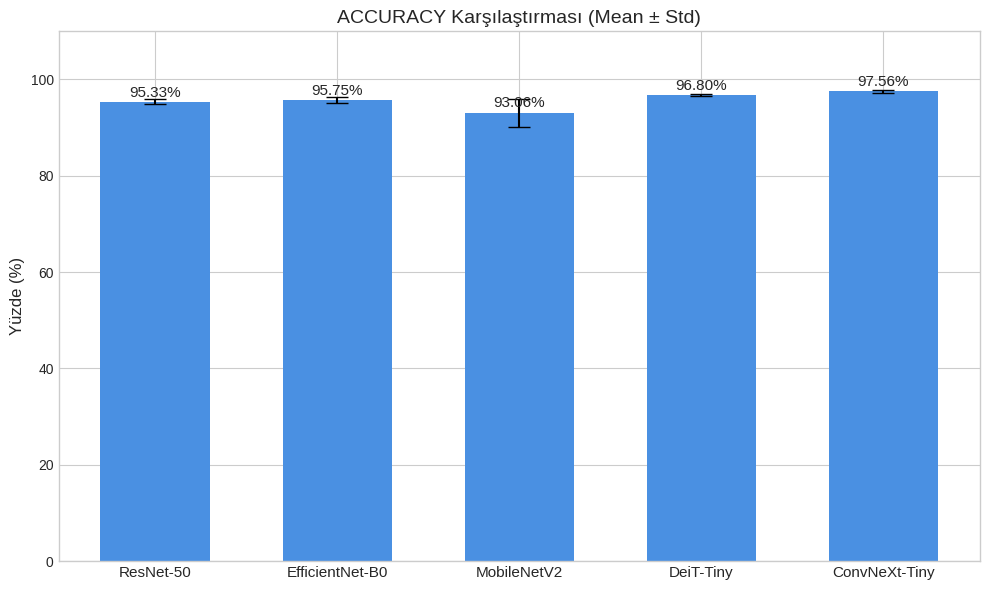

ACCURACY grafiği kaydedildi: ./results_fast/comparison_plots/accuracy_comparison.png


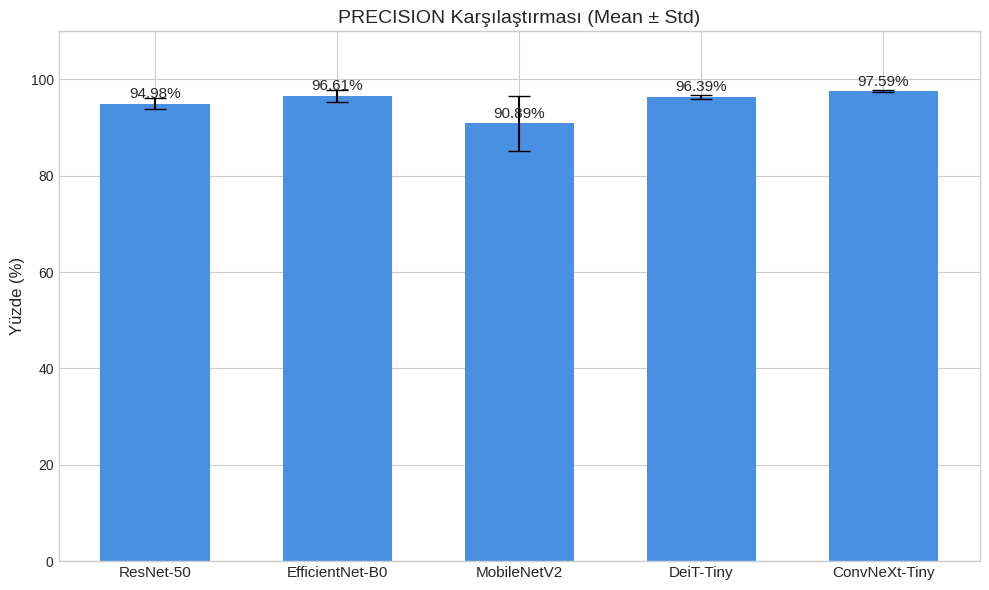

PRECISION grafiği kaydedildi: ./results_fast/comparison_plots/precision_comparison.png


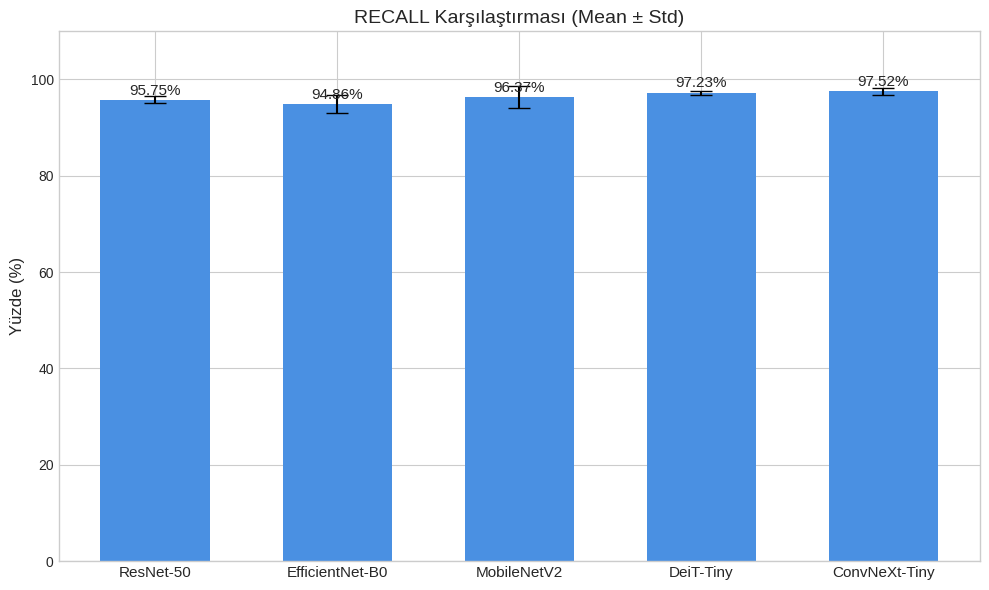

RECALL grafiği kaydedildi: ./results_fast/comparison_plots/recall_comparison.png


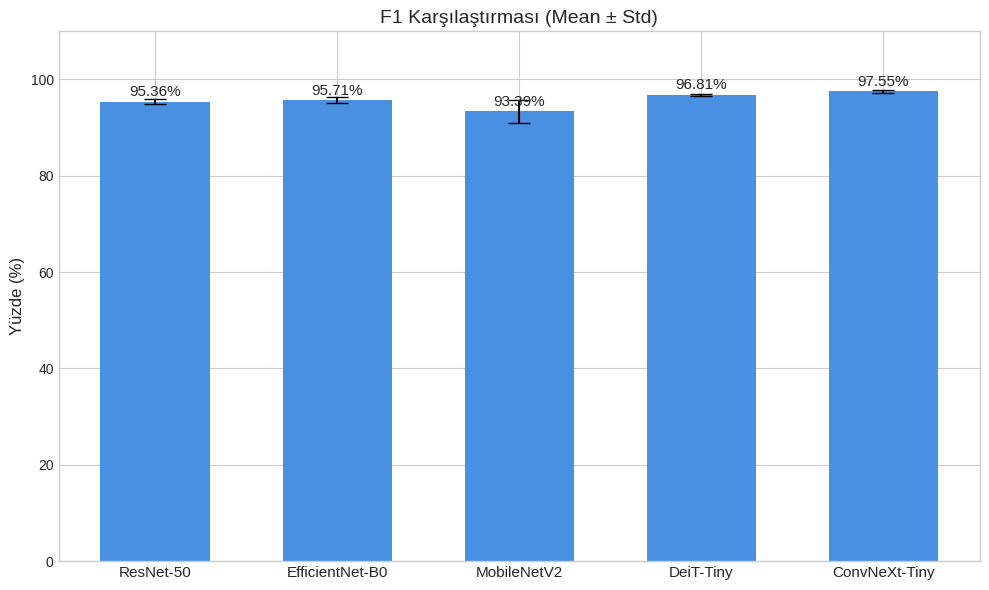

F1 grafiği kaydedildi: ./results_fast/comparison_plots/f1_comparison.png


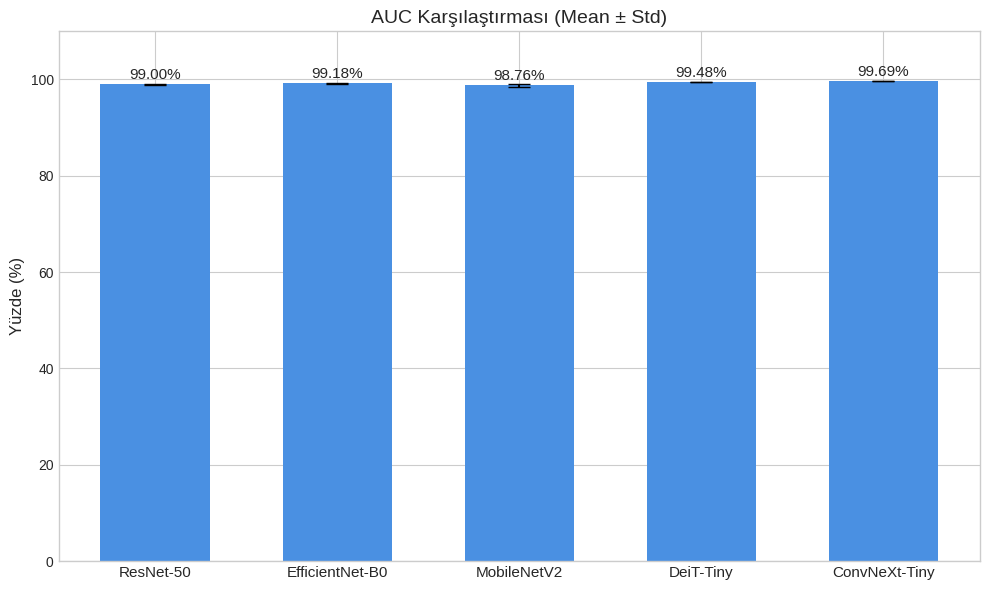

AUC grafiği kaydedildi: ./results_fast/comparison_plots/auc_comparison.png

Tüm karşılaştırma grafikleri oluşturuldu!
Grafikler klasörü: ./results_fast/comparison_plots


In [ ]:
# =========================
# 8. HÜCRE — MODEL KARŞILAŞTIRMA GRAFİKLERİ
# =========================

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

BASE_OUT = "./results_fast"
summary_path = f"{BASE_OUT}/summary_all_models.csv"

if not os.path.exists(summary_path):
    raise FileNotFoundError("summary_all_models.csv bulunamadı. Önce 7. hücreyi çalıştırın.")

summary_df = pd.read_csv(summary_path)

metrics = ["accuracy", "precision", "recall", "f1", "auc"]
model_names = summary_df["model"].tolist()

# Akademik stil
plt.style.use("seaborn-v0_8-whitegrid")

# Grafik klasörü
plot_dir = f"{BASE_OUT}/comparison_plots"
os.makedirs(plot_dir, exist_ok=True)

for metric in metrics:
    means = summary_df[f"{metric}_mean"].values
    stds = summary_df[f"{metric}_std"].values

    x = np.arange(len(model_names))
    width = 0.6

    fig, ax = plt.subplots(figsize=(10, 6))

    bars = ax.bar(x, means, yerr=stds, capsize=8, width=width, color="#4A90E2")

    # değerleri barların üzerine yazalım
    for i, val in enumerate(means):
        ax.text(i, val + 0.5, f"{val:.2f}%", ha="center", va="bottom", fontsize=11)

    ax.set_xticks(x)
    ax.set_xticklabels(model_names, fontsize=11)
    ax.set_ylabel("Yüzde (%)", fontsize=12)
    ax.set_title(f"{metric.upper()} Karşılaştırması (Mean ± Std)", fontsize=14)
    ax.set_ylim(0, 110)

    plt.tight_layout()

    save_path = f"{plot_dir}/{metric}_comparison.png"
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

    print(f"{metric.upper()} grafiği kaydedildi: {save_path}")

print("\nTüm karşılaştırma grafikleri oluşturuldu!")
print(f"Grafikler klasörü: {plot_dir}")


In [ ]:
import os

base = "./results_fast/convnext-tiny"

for fold in ["fold1", "fold2", "fold3", "fold4", "fold5"]:
    fold_path = os.path.join(base, fold)
    print(f"\n🔵 {fold} içeriği:", os.listdir(fold_path))

    # checkpoint içeriğini gösterelim
    for sub in os.listdir(fold_path):
        sub_path = os.path.join(fold_path, sub)
        if os.path.isdir(sub_path):
            print(f"   📁 {sub} içeriği:", os.listdir(sub_path))



🔵 fold1 içeriği: ['checkpoint-1336']
   📁 checkpoint-1336 içeriği: ['rng_state.pth', 'trainer_state.json', 'optimizer.pt', 'scaler.pt', 'scheduler.pt', 'model.safetensors', 'config.json', 'training_args.bin']

🔵 fold2 içeriği: ['checkpoint-1336']
   📁 checkpoint-1336 içeriği: ['rng_state.pth', 'trainer_state.json', 'optimizer.pt', 'scaler.pt', 'scheduler.pt', 'model.safetensors', 'config.json', 'training_args.bin']

🔵 fold3 içeriği: ['checkpoint-1670']
   📁 checkpoint-1670 içeriği: ['rng_state.pth', 'trainer_state.json', 'optimizer.pt', 'scaler.pt', 'scheduler.pt', 'model.safetensors', 'config.json', 'training_args.bin']

🔵 fold4 içeriği: ['checkpoint-668']
   📁 checkpoint-668 içeriği: ['rng_state.pth', 'trainer_state.json', 'optimizer.pt', 'scaler.pt', 'scheduler.pt', 'model.safetensors', 'config.json', 'training_args.bin']

🔵 fold5 içeriği: ['checkpoint-1670']
   📁 checkpoint-1670 içeriği: ['rng_state.pth', 'trainer_state.json', 'optimizer.pt', 'scaler.pt', 'scheduler.pt', 'model.sa

In [ ]:
# ==========================================================
# 9. HÜCRE — SAFETENSORS AĞIRLIKLARI + HF PROCESSOR İLE FINAL TEST
# ==========================================================

import os
import numpy as np
import pandas as pd
import torch
from PIL import Image
from datasets import Dataset
from sklearn.metrics import confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
from transformers import AutoImageProcessor, AutoModelForImageClassification

# ---------------------------------
# 0) KONTROLLER
# ---------------------------------
if "kilitli_test_df" not in locals():
    raise ValueError("kilitli_test_df bulunamadı.")

summary_df = pd.read_csv("./results_fast/summary_all_models.csv")

# ---------------------------------
# 1) AUC mean'e göre en iyi modeli seç
# ---------------------------------
best = summary_df.sort_values("auc_mean", ascending=False).iloc[0]
best_model_name = best["model"]

pretty_to_tag = {
    "ResNet-50": "resnet50",
    "EfficientNet-B0": "efficientnetb0",
    "MobileNetV2": "mobilenetv2",
    "DeiT-Tiny": "deit-tiny",
    "ConvNeXt-Tiny": "convnext-tiny",
}

pretty_to_hf = {
    "ResNet-50": "microsoft/resnet-50",
    "EfficientNet-B0": "google/efficientnet-b0",
    "MobileNetV2": "google/mobilenet_v2_1.0_224",
    "DeiT-Tiny": "facebook/deit-tiny-patch16-224",
    "ConvNeXt-Tiny": "facebook/convnext-tiny-224",
}

tag = pretty_to_tag[best_model_name]
hf_name = pretty_to_hf[best_model_name]

print(f"\n📌 En iyi model: {best_model_name}")
print(f"HF modeli: {hf_name}")

model_dir = f"./results_fast/{tag}"

# ---------------------------------
# 2) Fold CSV'yi oku → En iyi fold'u bul
# ---------------------------------
fold_df = pd.read_csv(f"{model_dir}/{tag}_results.csv")
best_fold = int(fold_df.sort_values("auc", ascending=False).iloc[0]["fold"])

print(f"📌 En iyi fold: Fold {best_fold}")

# ---------------------------------
# 3) Fold içindeki checkpoint klasörünü bul
# ---------------------------------
fold_path = os.path.join(model_dir, f"fold{best_fold}")

checkpoint_dirs = [
    os.path.join(fold_path, d)
    for d in os.listdir(fold_path)
    if d.startswith("checkpoint")
]

if len(checkpoint_dirs) == 0:
    raise FileNotFoundError("Checkpoint klasörü bulunamadı!")

checkpoint_path = checkpoint_dirs[0]

print(f"🔥 Checkpoint bulundu:\n{checkpoint_path}")

# ---------------------------------
# 4) Processor HF modelden — Model checkpoint'ten yüklenir
# ---------------------------------

# HF processor (HER ZAMAN HF MODELİNDEN YÜKLENİR!)
processor = AutoImageProcessor.from_pretrained(hf_name)

# Model fold checkpoint klasöründen yüklenir (model.safetensors otomatik bulunur)
model = AutoModelForImageClassification.from_pretrained(
    checkpoint_path,           # eğitimli checkpoint
    num_labels=2,
    id2label=id2label,
    label2id=label2id
)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()

print("✔ Eğitimli model başarıyla yüklendi!")

# ---------------------------------
# 5) Test seti transform
# ---------------------------------
test_ds = Dataset.from_pandas(kilitli_test_df.reset_index(drop=True))

def test_transform(batch):
    imgs = [Image.open(fp).convert("RGB") for fp in batch["filepath"]]
    out = processor(imgs, return_tensors="pt")
    batch["pixel_values"] = out["pixel_values"]
    return batch

test_ds.set_transform(test_transform)

# ---------------------------------
# 6) Tahmin döngüsü
# ---------------------------------
all_logits = []
all_labels = []

for i in range(len(test_ds)):
    item = test_ds[i]
    pv = item["pixel_values"].unsqueeze(0).to(device)

    with torch.no_grad():
        out = model(pixel_values=pv)

    all_logits.append(out.logits.cpu().numpy()[0])
    all_labels.append(item["label"])

all_logits = np.array(all_logits)
all_labels = np.array(all_labels)

probs = torch.softmax(torch.tensor(all_logits), dim=1).numpy()
y_pred = probs.argmax(axis=1)
y_score = probs[:, 1]

# ---------------------------------
# 7) Metrikler
# ---------------------------------
accuracy  = np.mean(y_pred == all_labels)
precision = precision_metric.compute(predictions=y_pred, references=all_labels, average='binary')['precision']
recall    = recall_metric.compute(predictions=y_pred, references=all_labels, average='binary')['recall']
f1        = f1_metric.compute(predictions=y_pred, references=all_labels, average='binary')['f1']
auc       = roc_auc_score(all_labels, y_score)

# ---------------------------------
# 8) CM ve ROC Kaydet
# ---------------------------------
OUT = "./results_fast/final_test_evaluation"
os.makedirs(OUT, exist_ok=True)

# CM
cm = confusion_matrix(all_labels, y_pred)
fig, ax = plt.subplots()
ax.imshow(cm, cmap="Blues")
for (i,j),v in np.ndenumerate(cm):
    ax.text(j, i, str(v), ha='center', va='center')
plt.title(f"Final CM — {best_model_name}")
plt.savefig(f"{OUT}/final_CM.png", dpi=300)
plt.close()

# ROC
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(all_labels, y_score)
fig, ax = plt.subplots()
ax.plot(fpr, tpr, label=f"AUC={auc:.4f}")
ax.plot([0,1], [0,1], "--")
plt.title(f"Final ROC — {best_model_name}")
plt.legend()
plt.savefig(f"{OUT}/final_ROC.png", dpi=300)
plt.close()

# CSV
pd.DataFrame([{
    "model": best_model_name,
    "fold": best_fold,
    "checkpoint": checkpoint_path,
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1,
    "auc": auc
}]).to_csv(f"{OUT}/final_metrics.csv", index=False)

print("\n=== 📘 FİNAL TEST SONUÇLARI ===")
print(pd.DataFrame([{
    "model": best_model_name,
    "fold": best_fold,
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1,
    "auc": auc
}]))

print(f"\n📁 Sonuçlar kaydedildi: {OUT}")



📌 En iyi model: ConvNeXt-Tiny
HF modeli: facebook/convnext-tiny-224
📌 En iyi fold: Fold 1
🔥 Checkpoint bulundu:
./results_fast/convnext-tiny/fold1/checkpoint-1336
✔ Eğitimli model başarıyla yüklendi!

=== 📘 FİNAL TEST SONUÇLARI ===
           model  fold  accuracy  precision  recall    f1  auc
0  ConvNeXt-Tiny     1      0.97       0.97    0.98  0.97  1.0

📁 Sonuçlar kaydedildi: ./results_fast/final_test_evaluation


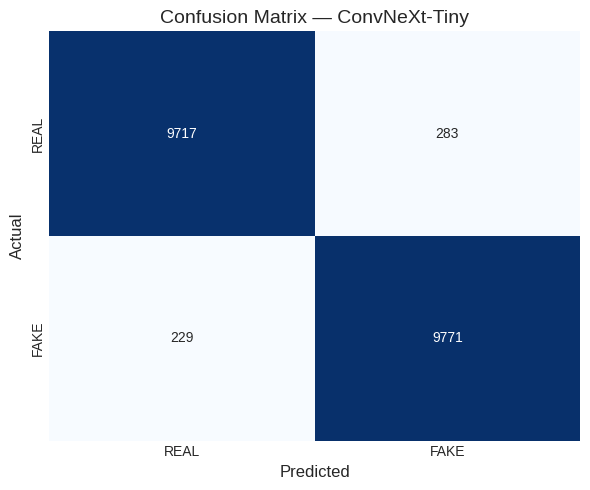

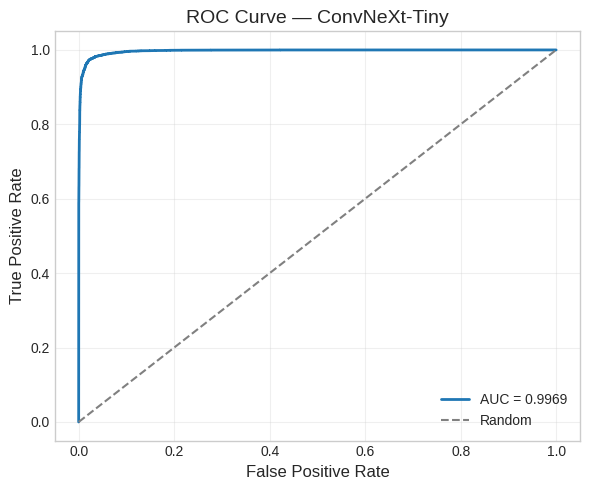

📁 Profesyonel CM + ROC grafiklerin hazır!


In [ ]:
# ======================================================
# 10. HÜCRE — PROFESYONEL HEATMAP CM + ROC
# ======================================================

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve
import numpy as np

OUT = "./results_fast/final_test_evaluation"

# ------------------------------
# CM Heatmap
# ------------------------------

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["REAL", "FAKE"],
            yticklabels=["REAL", "FAKE"])
plt.title(f"Confusion Matrix — {best_model_name}", fontsize=14)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.tight_layout()
plt.savefig(f"{OUT}/final_CM_heatmap.png", dpi=300)
plt.show()

# ------------------------------
# ROC Curve (estetik)
# ------------------------------

fpr, tpr, _ = roc_curve(all_labels, y_score)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, linewidth=2, label=f"AUC = {auc:.4f}")
plt.plot([0,1], [0,1], linestyle='--', color='gray', label="Random")
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title(f"ROC Curve — {best_model_name}", fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(f"{OUT}/final_ROC_pretty.png", dpi=300)
plt.show()

print("📁 Profesyonel CM + ROC grafiklerin hazır!")


In [ ]:
# ===========================================================
# 11. HÜCRE — ConvNeXt-Tiny Latency (Gecikme) Ölçümü
# ===========================================================

import time
import numpy as np
import torch
from PIL import Image

# Model zaten yüklü: model, processor, device
# kilitli_test_df de mevcut

print("📌 Gecikme testi başlıyor (ConvNeXt-Tiny)...")

# ------------------------------------------------
# 1) Test için 50 rastgele örnek seçelim
# ------------------------------------------------
sample_df = kilitli_test_df.sample(50, random_state=42).reset_index(drop=True)

latencies = []

# Model eval modunda
model.eval()

# ------------------------------------------------
# 2) Tek tek görüntüler için latency ölçümü
# ------------------------------------------------
for i in range(len(sample_df)):
    img = Image.open(sample_df.loc[i, "filepath"]).convert("RGB")

    # preprocess
    inp = processor(img, return_tensors="pt")["pixel_values"].to(device)

    # zaman ölçümü
    torch.cuda.synchronize(device) if device == "cuda" else None
    t0 = time.time()

    with torch.no_grad():
        _ = model(pixel_values=inp)

    torch.cuda.synchronize(device) if device == "cuda" else None
    t1 = time.time()

    latencies.append(t1 - t0)

latencies = np.array(latencies)

print("\n=== 🧭 GECİKME SONUÇLARI (Single Image) ===")
print(f"En iyi: {latencies.min()*1000:.2f} ms")
print(f"En kötü: {latencies.max()*1000:.2f} ms")
print(f"Ortalama: {latencies.mean()*1000:.2f} ms")

# ------------------------------------------------
# 3) Batch latency ölçümü (batch = 32)
# ------------------------------------------------
BATCH = 32
batch_imgs = []

for fp in sample_df["filepath"].iloc[:BATCH]:
    img = Image.open(fp).convert("RGB")
    batch_imgs.append(img)

batch_inp = processor(batch_imgs, return_tensors="pt")["pixel_values"].to(device)

torch.cuda.synchronize(device) if device == "cuda" else None
t0 = time.time()

with torch.no_grad():
    _ = model(pixel_values=batch_inp)

torch.cuda.synchronize(device) if device == "cuda" else None
t1 = time.time()

batch_latency = t1 - t0
throughput = BATCH / batch_latency

print("\n=== 🚀 BATCH GECİKME SONUÇLARI (32 görüntü) ===")
print(f"Batch latency: {batch_latency*1000:.2f} ms")
print(f"Throughput: {throughput:.2f} görüntü/saniye")

print("\n📁 Gecikme testi tamamlandı.")


📌 Gecikme testi başlıyor (ConvNeXt-Tiny)...

=== 🧭 GECİKME SONUÇLARI (Single Image) ===
En iyi: 7.35 ms
En kötü: 18.78 ms
Ortalama: 10.40 ms

=== 🚀 BATCH GECİKME SONUÇLARI (32 görüntü) ===
Batch latency: 3589.19 ms
Throughput: 8.92 görüntü/saniye

📁 Gecikme testi tamamlandı.


In [ ]:
# =======================================================
# 12. HÜCRE — TÜM MODELLER İÇİN LATENCY TESTİ (Tek Hücre)
# =======================================================

import time
import numpy as np
import torch
from PIL import Image
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"📌 Cihaz: {device}")

# ----------------------------------------------
# MODELLER
# ----------------------------------------------
models = {
    "ResNet50": "microsoft/resnet-50",
    "EfficientNetB0": "google/efficientnet-b0",
    "MobileNetV2": "google/mobilenet_v2_1.0_224",
    "DeiT-Tiny": "facebook/deit-tiny-patch16-224",
    "ConvNeXt-Tiny": "facebook/convnext-tiny-224"
}

# 20 örnek seçelim
sample_df = kilitli_test_df.sample(20, random_state=42).reset_index(drop=True)

results = []

print("\n🚀 TÜM MODELLER İÇİN LATENCY TESTİ BAŞLIYOR...\n")

for model_name, hf_name in models.items():
    print(f"=== ⏱ {model_name} test ediliyor... ===")

    # --- Model ve processor yükle ---
    processor = AutoImageProcessor.from_pretrained(hf_name)
    model = AutoModelForImageClassification.from_pretrained(
        hf_name, num_labels=2, ignore_mismatched_sizes=True
    ).to(device)
    model.eval()

    latencies = []

    # --- 20 görüntü üzerinde latency ölç ---
    for i in range(len(sample_df)):
        img = Image.open(sample_df.loc[i, "filepath"]).convert("RGB")

        inp = processor(img, return_tensors="pt")["pixel_values"].to(device)

        torch.cuda.synchronize(device) if device == "cuda" else None
        t0 = time.time()

        with torch.no_grad():
            _ = model(pixel_values=inp)

        torch.cuda.synchronize(device) if device == "cuda" else None
        t1 = time.time()

        latencies.append(t1 - t0)

    latencies = np.array(latencies)

    avg_ms = latencies.mean() * 1000
    min_ms = latencies.min() * 1000
    max_ms = latencies.max() * 1000
    throughput = 1.0 / (latencies.mean())  # img/s

    print(f"{model_name} → Ortalama: {avg_ms:.2f} ms | En iyi: {min_ms:.2f} ms | En kötü: {max_ms:.2f} ms | Throughput: {throughput:.2f} img/s\n")

    results.append({
        "Model": model_name,
        "Avg Latency (ms)": round(avg_ms, 2),
        "Best (ms)": round(min_ms, 2),
        "Worst (ms)": round(max_ms, 2),
        "Throughput (img/s)": round(throughput, 2)
    })

# ----------------------------------------------
# TABLOYU BASTIR
# ----------------------------------------------
df_latency = pd.DataFrame(results)
print("\n=== 📊 TÜM MODELLER LATENCY SONUÇ TABLOSU ===\n")
print(df_latency.to_string(index=False))

# Kaydetmek isteyenler için:
df_latency.to_csv("./results_fast/latency_results_all_models.csv", index=False)
print("\n📁 latency_results_all_models.csv kaydedildi!")


📌 Cihaz: cuda

🚀 TÜM MODELLER İÇİN LATENCY TESTİ BAŞLIYOR...

=== ⏱ ResNet50 test ediliyor... ===


Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([2, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ResNet50 → Ortalama: 30.65 ms | En iyi: 11.07 ms | En kötü: 178.32 ms | Throughput: 32.63 img/s

=== ⏱ EfficientNetB0 test ediliyor... ===


Some weights of EfficientNetForImageClassification were not initialized from the model checkpoint at google/efficientnet-b0 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1280]) in the checkpoint and torch.Size([2, 1280]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EfficientNetB0 → Ortalama: 30.35 ms | En iyi: 14.49 ms | En kötü: 196.79 ms | Throughput: 32.95 img/s

=== ⏱ MobileNetV2 test ediliyor... ===


Some weights of MobileNetV2ForImageClassification were not initialized from the model checkpoint at google/mobilenet_v2_1.0_224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1001]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1001, 1280]) in the checkpoint and torch.Size([2, 1280]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


MobileNetV2 → Ortalama: 23.89 ms | En iyi: 13.86 ms | En kötü: 47.42 ms | Throughput: 41.86 img/s

=== ⏱ DeiT-Tiny test ediliyor... ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/deit-tiny-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([2, 192]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DeiT-Tiny → Ortalama: 16.72 ms | En iyi: 12.46 ms | En kötü: 60.43 ms | Throughput: 59.82 img/s

=== ⏱ ConvNeXt-Tiny test ediliyor... ===


Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-tiny-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ConvNeXt-Tiny → Ortalama: 10.62 ms | En iyi: 9.57 ms | En kötü: 13.18 ms | Throughput: 94.14 img/s


=== 📊 TÜM MODELLER LATENCY SONUÇ TABLOSU ===

         Model  Avg Latency (ms)  Best (ms)  Worst (ms)  Throughput (img/s)
      ResNet50             30.65      11.07      178.32               32.63
EfficientNetB0             30.35      14.49      196.79               32.95
   MobileNetV2             23.89      13.86       47.42               41.86
     DeiT-Tiny             16.72      12.46       60.43               59.82
 ConvNeXt-Tiny             10.62       9.57       13.18               94.14

📁 latency_results_all_models.csv kaydedildi!


In [ ]:
# =======================================================
# 6. HÜCRE – Hibrit Model Eğitim (CPU XGBoost)
# =======================================================

from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score
)

print("\n📌 Eğitim seti özellikleri çıkarılıyor...")
X_train = extract_features(egitim_alt_kume_df["filepath"].tolist())
y_train = egitim_alt_kume_df["label"].values

print("\n📌 Test seti özellikleri çıkarılıyor...")
X_test = extract_features(kilitli_test_df["filepath"].tolist())
y_test = kilitli_test_df["label"].values


# ----------------------------------------
#  XGBOOST MODELİ (CPU, hist)
# ----------------------------------------
print("\n📌 XGBoost eğitiliyor...")

xgb = XGBClassifier(
    n_estimators=400,
    max_depth=10,
    learning_rate=0.03,
    subsample=0.9,
    colsample_bytree=0.8,
    eval_metric="logloss",
    tree_method="hist",   # CPU uyumlu, hızlı
)

xgb.fit(X_train, y_train)

print("✓ XGBoost eğitimi tamamlandı.")


# ----------------------------------------
#  TEST DEĞERLENDİRME
# ----------------------------------------
y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)[:, 1]

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)
auc  = roc_auc_score(y_test, y_prob)


# ----------------------------------------
#  SONUÇ
# ----------------------------------------
print("\n=== 📘 HİBRİT MODEL – KİLİTLİ TEST SONUÇLARI ===")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUC:       {auc:.4f}")

# Kaydet
import pandas as pd
res = pd.DataFrame({
    "metric": ["accuracy", "precision", "recall", "f1_score", "auc"],
    "value":  [acc, prec, rec, f1, auc]
})
res.to_csv("./results_fast/hybrid_model_results.csv", index=False)
print("\n📁 Sonuçlar kaydedildi: results_fast/hybrid_model_results.csv")



📌 Eğitim seti özellikleri çıkarılıyor...


Feature Extraction: 100%|██████████| 20000/20000 [07:30<00:00, 44.38it/s]


✔ Final feature matrix shape: (20000, 2048)

📌 Test seti özellikleri çıkarılıyor...


Feature Extraction: 100%|██████████| 20000/20000 [07:25<00:00, 44.84it/s]


✔ Final feature matrix shape: (20000, 2048)

📌 XGBoost eğitiliyor...
✓ XGBoost eğitimi tamamlandı.

=== 📘 HİBRİT MODEL – KİLİTLİ TEST SONUÇLARI ===
Accuracy:  0.9256
Precision: 0.9244
Recall:    0.9270
F1 Score:  0.9257
AUC:       0.9791

📁 Sonuçlar kaydedildi: results_fast/hybrid_model_results.csv


In [ ]:
# =======================================================
# 5. HÜCRE – ConvNeXt-Tiny Feature Extraction (768D)
# =======================================================

import torch
import numpy as np
from tqdm import tqdm
from PIL import Image
from transformers import AutoImageProcessor, AutoModel

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Cihaz:", device)

model_name = "facebook/convnext-tiny-224"

processor = AutoImageProcessor.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)
model.eval()

def extract_features(filepath_list):
    feats = []

    for fp in tqdm(filepath_list, desc="ConvNeXt Features"):
        img = Image.open(fp).convert("RGB")

        inp = processor(img, return_tensors="pt")["pixel_values"].to(device)

        with torch.no_grad():
            out = model(inp)

        # pooler_output → (1, 768)
        vec = out.pooler_output.squeeze().cpu().numpy()

        feats.append(vec)

    feats = np.vstack(feats)   # → (N, 768)
    print("✔ Feature shape:", feats.shape)
    return feats


Cihaz: cuda


In [ ]:
# =======================================================
# 6. HÜCRE – Optimize Hibrit Model (ConvNeXt-Tiny + XGBoost)
# =======================================================

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

print("\n📌 Eğitim seti özellikleri çıkarılıyor...")
X_train = extract_features(egitim_alt_kume_df["filepath"].tolist())
y_train = egitim_alt_kume_df["label"].values

print("\n📌 Test seti özellikleri çıkarılıyor...")
X_test = extract_features(kilitli_test_df["filepath"].tolist())
y_test = kilitli_test_df["label"].values

print("\n📌 XGBoost eğitiliyor...")

xgb = XGBClassifier(
    n_estimators=600,
    max_depth=9,
    learning_rate=0.03,
    subsample=0.95,
    colsample_bytree=0.9,
    min_child_weight=1,
    gamma=0.0,
    reg_lambda=1.0,
    reg_alpha=0.0,
    eval_metric="logloss",
    tree_method="hist",   # CPU hızlı modu
)

xgb.fit(X_train, y_train)

print("✓ Eğitim tamamlandı.")

y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)[:, 1]

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)
auc  = roc_auc_score(y_test, y_prob)

print("\n=== 📘 OPTİMİZE HİBRİT MODEL — KİLİTLİ TEST ===")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUC:       {auc:.4f}")



📌 Eğitim seti özellikleri çıkarılıyor...


ConvNeXt Features: 100%|██████████| 20000/20000 [03:16<00:00, 101.99it/s]


✔ Feature shape: (20000, 768)

📌 Test seti özellikleri çıkarılıyor...


ConvNeXt Features: 100%|██████████| 20000/20000 [03:11<00:00, 104.47it/s]


✔ Feature shape: (20000, 768)

📌 XGBoost eğitiliyor...
✓ Eğitim tamamlandı.

=== 📘 OPTİMİZE HİBRİT MODEL — KİLİTLİ TEST ===
Accuracy:  0.9145
Precision: 0.9128
Recall:    0.9165
F1 Score:  0.9147
AUC:       0.9734


In [ ]:
# =======================================================
# 7. HÜCRE – Hibrit Model (ConvNeXt Features + SVM)
# =======================================================

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# -------------------------------------------------------
# 1) Özellikler hazır mı kontrol edelim; yoksa tekrar çıkaralım
# -------------------------------------------------------
if 'X_train' not in locals() or 'X_test' not in locals():
    print("📌 X_train / X_test bulunamadı, yeniden feature çıkarılıyor...")

    print("\n📌 Eğitim seti özellikleri çıkarılıyor (ConvNeXt)...")
    X_train = extract_features(egitim_alt_kume_df["filepath"].tolist())
    y_train = egitim_alt_kume_df["label"].values

    print("\n📌 Test seti özellikleri çıkarılıyor (ConvNeXt)...")
    X_test = extract_features(kilitli_test_df["filepath"].tolist())
    y_test = kilitli_test_df["label"].values
else:
    print("✅ Mevcut X_train / X_test kullanılacak.")
    y_train = egitim_alt_kume_df["label"].values
    y_test = kilitli_test_df["label"].values

# -------------------------------------------------------
# 2) SVM Pipeline (Scaler + RBF Kernel SVM)
# -------------------------------------------------------
print("\n📌 SVM hibrit model eğitiliyor...")

svm_clf = make_pipeline(
    StandardScaler(),
    SVC(
        C=5.0,
        kernel="rbf",
        gamma="scale",
        class_weight=None,   # istersen 'balanced' da deneyebilirsin
        probability=True,    # AUC için gerekli (predict_proba)
        max_iter=-1          # sınırsız iterasyon (erken durursa uyarı verir)
    )
)

svm_clf.fit(X_train, y_train)

print("✓ SVM hibrit eğitimi tamamlandı.")

# -------------------------------------------------------
# 3) Kilitli test setinde değerlendirme
# -------------------------------------------------------
y_pred = svm_clf.predict(X_test)
y_prob = svm_clf.predict_proba(X_test)[:, 1]

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)
auc  = roc_auc_score(y_test, y_prob)

print("\n=== 📘 SVM HİBRİT MODEL – KİLİTLİ TEST SONUÇLARI ===")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUC:       {auc:.4f}")

# İstersen kaydedelim
import pandas as pd

svm_res = pd.DataFrame({
    "metric": ["accuracy", "precision", "recall", "f1_score", "auc"],
    "value":  [acc, prec, rec, f1, auc]
})

svm_res.to_csv("./results_fast/hybrid_svm_results.csv", index=False)
print("\n📁 Sonuçlar kaydedildi: results_fast/hybrid_svm_results.csv")


✅ Mevcut X_train / X_test kullanılacak.

📌 SVM hibrit model eğitiliyor...
✓ SVM hibrit eğitimi tamamlandı.

=== 📘 SVM HİBRİT MODEL – KİLİTLİ TEST SONUÇLARI ===
Accuracy:  0.9517
Precision: 0.9494
Recall:    0.9544
F1 Score:  0.9519
AUC:       0.9908

📁 Sonuçlar kaydedildi: results_fast/hybrid_svm_results.csv


In [ ]:
# ================================
# 1) ConvNeXt Feature Extractor TANIMI
# ================================
import torch
import timm
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

convnext_model = timm.create_model(
    "convnext_base",
    pretrained=True,
    num_classes=0
).to(device)

convnext_model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

def extract_features(filepaths):
    feats = []
    for p in filepaths:
        img = Image.open(p).convert("RGB")
        img = transform(img).unsqueeze(0).to(device)
        with torch.no_grad():
            f = convnext_model(img).cpu().numpy().flatten()
        feats.append(f)
    return np.array(feats)

# ================================
# 2) EĞİTİM ÖZELLİKLERİNİ ÇIKAR
# ================================
print("📌 Eğitim özellikleri çıkarılıyor...")
X_train = extract_features(egitim_alt_kume_df["filepath"].tolist())
y_train = egitim_alt_kume_df["label"].values

# ================================
# 3) KAYDET 🚀 (bir daha çıkarmaya gerek yok!)
# ================================
np.save("/content/X_train_convnext.npy", X_train)
np.save("/content/y_train.npy", y_train)

print("✅ ÖZELLİKLER KAYDEDİLDİ!")


📌 Eğitim özellikleri çıkarılıyor...
✅ ÖZELLİKLER KAYDEDİLDİ!


In [ ]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold

# ===============================
# 1) KAYITLI ÖZELLİKLERİ YÜKLE 🚀
# ===============================
X_train = np.load("/content/X_train_convnext.npy")
y_train = np.load("/content/y_train.npy")

print("✔ X_train ve y_train başarıyla yüklendi.")
print("X_train shape:", X_train.shape)

# ===============================
# 2) 5-FOLD HIZLI HİBRİT SVM
# ===============================
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accs, precs, recs, f1s, aucs = [], [], [], [], []
fold = 1

for train_idx, val_idx in skf.split(X_train, y_train):

    print(f"\n🔸 Fold {fold} eğitiliyor...")

    svm_clf = make_pipeline(
        StandardScaler(),
        SVC(
            C=5.0,
            kernel="rbf",
            gamma="scale",
            probability=True
        )
    )

    svm_clf.fit(X_train[train_idx], y_train[train_idx])

    y_pred = svm_clf.predict(X_train[val_idx])
    y_prob = svm_clf.predict_proba(X_train[val_idx])[:, 1]

    accs.append(accuracy_score(y_train[val_idx], y_pred))
    precs.append(precision_score(y_train[val_idx], y_pred))
    recs.append(recall_score(y_train[val_idx], y_pred))
    f1s.append(f1_score(y_train[val_idx], y_pred))
    aucs.append(roc_auc_score(y_train[val_idx], y_prob))

    print(f"Fold {fold} → Acc: {accs[-1]:.4f}, Prec: {precs[-1]:.4f}, Rec: {recs[-1]:.4f}, F1: {f1s[-1]:.4f}, AUC: {aucs[-1]:.4f}")

    fold += 1

# ===============================
# 3) ORTALAMA SONUÇ
# ===============================
print("\n=== 📘 ORTALAMA 5-FOLD SONUÇLAR ===")
print(f"Accuracy:  {np.mean(accs):.4f}")
print(f"Precision: {np.mean(precs):.4f}")
print(f"Recall:    {np.mean(recs):.4f}")
print(f"F1 Score:  {np.mean(f1s):.4f}")
print(f"AUC:       {np.mean(aucs):.4f}")


✔ X_train ve y_train başarıyla yüklendi.
X_train shape: (20000, 1024)

🔸 Fold 1 eğitiliyor...
Fold 1 → Acc: 0.9667, Prec: 0.9642, Rec: 0.9695, F1: 0.9668, AUC: 0.9944

🔸 Fold 2 eğitiliyor...
Fold 2 → Acc: 0.9698, Prec: 0.9649, Rec: 0.9750, F1: 0.9699, AUC: 0.9965

🔸 Fold 3 eğitiliyor...
Fold 3 → Acc: 0.9700, Prec: 0.9686, Rec: 0.9715, F1: 0.9700, AUC: 0.9958

🔸 Fold 4 eğitiliyor...
Fold 4 → Acc: 0.9695, Prec: 0.9686, Rec: 0.9705, F1: 0.9695, AUC: 0.9956

🔸 Fold 5 eğitiliyor...
Fold 5 → Acc: 0.9742, Prec: 0.9735, Rec: 0.9750, F1: 0.9743, AUC: 0.9964

=== 📘 ORTALAMA 5-FOLD SONUÇLAR ===
Accuracy:  0.9700
Precision: 0.9680
Recall:    0.9723
F1 Score:  0.9701
AUC:       0.9957


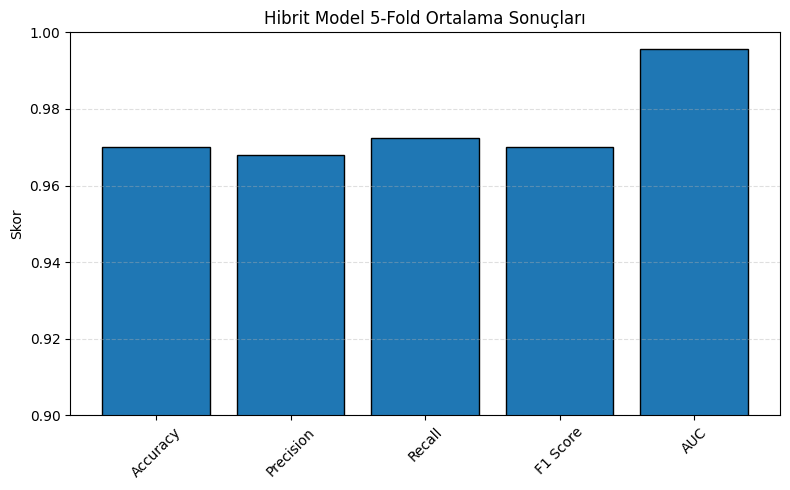

In [ ]:
# ===============================
# 1) Gerekli Kütüphaneler
# ===============================
import matplotlib.pyplot as plt
import numpy as np

# ===============================
# 2) Hibrit Model 5-Fold Ortalama Değerleri
# ===============================
metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "AUC"]
values = [0.9700, 0.9680, 0.9723, 0.9701, 0.9957]

# ===============================
# 3) Grafik Ayarları
# ===============================
plt.figure(figsize=(8,5))

plt.bar(metrics, values, edgecolor='black')

plt.title("Hibrit Model 5-Fold Ortalama Sonuçları")
plt.ylabel("Skor")

plt.ylim(0.9, 1.0)
plt.xticks(rotation=45)

plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()

# ===============================
# 4) Grafiği Göster
# ===============================
plt.show()


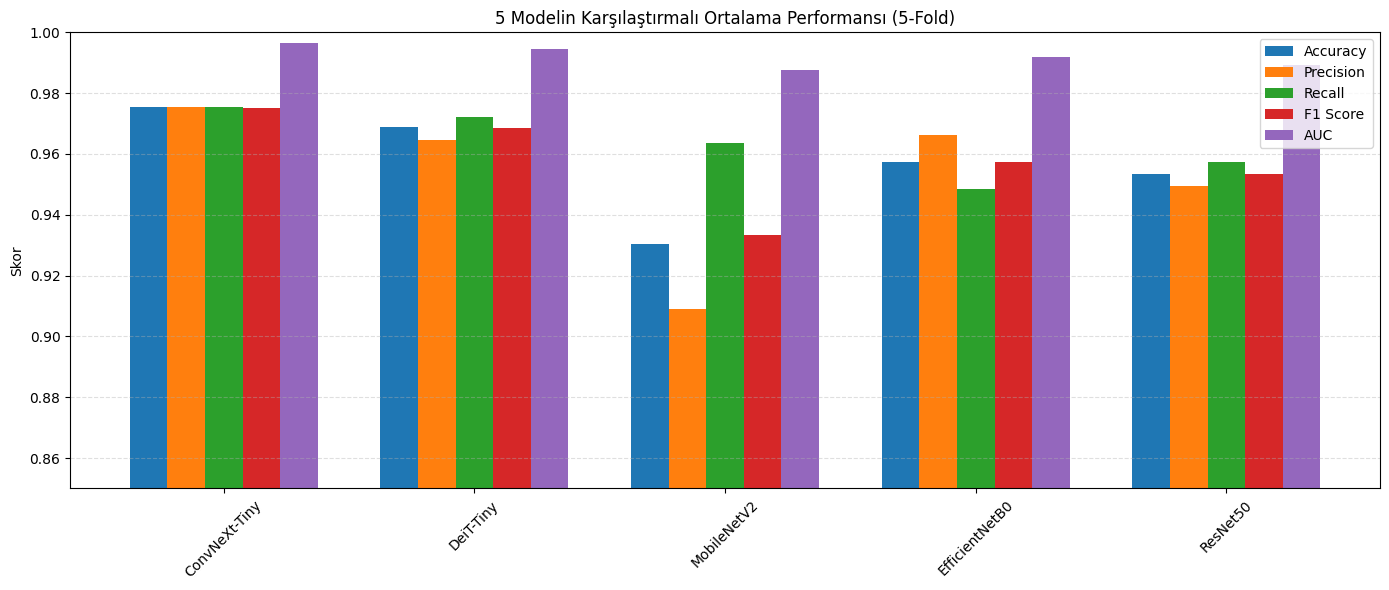

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ===============================
# 1) Model İsimleri
# ===============================
models = ["ConvNeXt-Tiny", "DeiT-Tiny", "MobileNetV2", "EfficientNetB0", "ResNet50"]

# ===============================
# 2) Ortalama Değerler (Senin Sonuçlarından)
# ===============================
accuracy  = [0.97555, 0.96875, 0.93025, 0.95750, 0.95355]
precision = [0.97530, 0.96475, 0.90891, 0.96611, 0.94942]
recall    = [0.97540, 0.97230, 0.96370, 0.94860, 0.95730]
f1        = [0.97513, 0.96849, 0.93346, 0.95727, 0.95337]
auc       = [0.99652, 0.99441, 0.98755, 0.99176, 0.98917]

# ===============================
# 3) Grafik Ayarları
# ===============================
x = np.arange(len(models))
width = 0.15  # çubuk genişliği

plt.figure(figsize=(14, 6))

plt.bar(x - 2*width, accuracy, width, label='Accuracy')
plt.bar(x - width, precision, width, label='Precision')
plt.bar(x, recall, width, label='Recall')
plt.bar(x + width, f1, width, label='F1 Score')
plt.bar(x + 2*width, auc, width, label='AUC')

plt.xticks(x, models, rotation=45)
plt.ylim(0.85, 1.00)

plt.ylabel("Skor")
plt.title("5 Modelin Karşılaştırmalı Ortalama Performansı (5-Fold)")

plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from scipy.stats import ttest_rel

convnext = np.array([97.45, 97.93, 97.38, 97.08, 97.95])
hybrid   = np.array([96.67, 96.98, 97.00, 96.95, 97.42])

t_stat, p_value = ttest_rel(convnext, hybrid)

print("t-istatistiği:", t_stat)
print("p-değeri:", p_value)


t-istatistiği: 3.8297167497420683
p-değeri: 0.018622614766500154


In [ ]:
import os

print(os.listdir("/content"))


['.config', 'archive.zip', 'cifake_data', 'sample_data']


In [ ]:
import os
os.listdir()


['.config', 'archive.zip', 'cifake_data', 'sample_data']

REAL sayısı: 477
FAKE sayısı: 523


Feature Extracting: 100%|██████████| 1000/1000 [00:08<00:00, 112.56it/s]


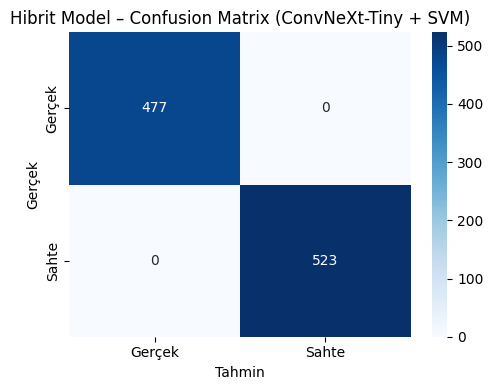

In [ ]:
import os
import numpy as np
import random
from PIL import Image
import timm
import torch
import torchvision.transforms as T
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# ===============================
# 0) Ayarlar
# ===============================
device = "cuda" if torch.cuda.is_available() else "cpu"
N = 1000  # kullanılacak örnek sayısı

# ===============================
# 1) CIFake Image Path'leri yükle
# ===============================
root = "/content/cifake_data/train"
classes = ["REAL", "FAKE"]

image_paths = []
labels = []

for idx, cls in enumerate(classes):
    folder = os.path.join(root, cls)
    for f in os.listdir(folder):
        image_paths.append(os.path.join(folder, f))
        labels.append(idx)

image_paths = np.array(image_paths)
labels = np.array(labels)

# ---- Karıştır ve ilk 1000 örneği al ----
indices = np.arange(len(image_paths))
np.random.shuffle(indices)

image_paths = image_paths[indices][:N]
labels = labels[indices][:N]

print("REAL sayısı:", np.sum(labels == 0))
print("FAKE sayısı:", np.sum(labels == 1))


# ===============================
# 2) ConvNeXt Tiny modelini yükle
# ===============================
model = timm.create_model("convnext_tiny", pretrained=True, num_classes=0).to(device)
model.eval()

transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],
                [0.229,0.224,0.225])
])

# ===============================
# 3) Hızlı özellik çıkarma
# ===============================
features = []

for img_path in tqdm(image_paths, desc="Feature Extracting"):
    img = Image.open(img_path).convert("RGB")
    x = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        feat = model(x).cpu().numpy()

    features.append(feat.squeeze())

X = np.array(features)
y = labels.copy()

# ===============================
# 4) SVM eğit
# ===============================

svm = make_pipeline(
    StandardScaler(),
    SVC(C=5.0, kernel="rbf", gamma="scale")
)

svm.fit(X, y)
y_pred = svm.predict(X)

# ===============================
# 5) Confusion Matrix çiz
# ===============================

cm = confusion_matrix(y, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Gerçek", "Sahte"],
    yticklabels=["Gerçek", "Sahte"]
)
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.title("Hibrit Model – Confusion Matrix (ConvNeXt-Tiny + SVM)")
plt.tight_layout()
plt.show()


In [ ]:
import os

print(os.listdir("/content"))


['.config', 'archive.zip', 'cifake_data', 'sample_data']


In [ ]:
import torch
import numpy as np
import timm
from tqdm import tqdm
from torchvision import transforms
from PIL import Image
import os

# ================================
# 1) GPU KONTROL
# ================================
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Kullanılan cihaz:", device)

# ================================
# 2) MODEL: ConvNeXt-Tiny (num_classes=0 → feature extractor)
# ================================
model = timm.create_model('convnext_tiny', pretrained=True, num_classes=0)
model.to(device)
model.eval()

# ================================
# 3) DÖNÜŞÜM
# ================================
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ================================
# 4) CIFAKE TRAIN KLASÖRÜ
# ================================
root = "/content/cifake_data/train"
classes = ["REAL", "FAKE"]

MAX_PER_CLASS = 10000   # her sınıftan 10.000 → toplam 20.000

features = []
labels = []

print("\nÖzellik çıkarma başlıyor...\n")

for label_idx, cls in enumerate(classes):
    folder = os.path.join(root, cls)
    img_list = os.listdir(folder)[:MAX_PER_CLASS]  # en hızlı yöntem

    for img_name in tqdm(img_list, desc=f"{cls}"):
        img_path = os.path.join(folder, img_name)

        img = Image.open(img_path).convert("RGB")
        img = transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            feat = model(img).cpu().numpy()   # 1024 boyutlu özellik

        features.append(feat.squeeze())
        labels.append(label_idx)

# ================================
# 5) NUMPY DÖNÜŞÜM
# ================================
X_train = np.array(features)
y_train = np.array(labels)

print("\n✔ X_train shape:", X_train.shape)
print("✔ y_train shape:", y_train.shape)

# ================================
# 6) DOSYALARI KAYDET
# ================================
np.save("X_train_convnext.npy", X_train)
np.save("y_train.npy", y_train)

print("\n🎉 Özellik çıkarma tamamlandı!")
print("📁 Kaydedilen dosyalar:")
print(" - X_train_convnext.npy")
print(" - y_train.npy")


Kullanılan cihaz: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



Özellik çıkarma başlıyor...



FAKE: 100%|██████████| 10000/10000 [01:39<00:00, 100.98it/s]



✔ X_train shape: (20000, 768)
✔ y_train shape: (20000,)

🎉 Özellik çıkarma tamamlandı!
📁 Kaydedilen dosyalar:
 - X_train_convnext.npy
 - y_train.npy


In [ ]:
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns

# ================================
# 1) VERİLERİ YÜKLE
# ================================
X = np.load("X_train_convnext.npy")
y = np.load("y_train.npy")

print("Veriler yüklendi:", X.shape, y.shape)

# ================================
# 2) 5-FOLD SVM EĞİTİMİ
# ================================
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cms = []
fprs = []
tprs = []
aucs = []

fold = 1

for train_idx, val_idx in skf.split(X, y):

    svm = make_pipeline(
        StandardScaler(),
        SVC(C=5.0, kernel="rbf", gamma="scale", probability=True)
    )

    svm.fit(X[train_idx], y[train_idx])

    y_pred  = svm.predict(X[val_idx])
    y_score = svm.predict_proba(X[val_idx])[:, 1]

    cm = confusion_matrix(y[val_idx], y_pred)
    cms.append(cm)

    fpr, tpr, _ = roc_curve(y[val_idx], y_score)
    fprs.append(fpr)
    tprs.append(tpr)

    auc_value = roc_auc_score(y[val_idx], y_score)
    aucs.append(auc_value)

    print(f"Fold {fold} AUC: {auc_value:.4f}")
    fold += 1

# ================================
# 3) ORTALAMA CONFUSION MATRIX
# ================================
avg_cm = np.mean(cms, axis=0).astype(int)
print("\nOrtalama CM:\n", avg_cm)

plt.figure(figsize=(6,5))
sns.heatmap(avg_cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["REAL", "FAKE"],
            yticklabels=["REAL", "FAKE"])
plt.title("Hybrid Model – Ortalama Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig("hybrid_confusion_matrix.png", dpi=300)
plt.show()

# ================================
# 4) ORTALAMA ROC EĞRİSİ
# ================================
plt.figure(figsize=(6,5))
for i in range(5):
    plt.plot(fprs[i], tprs[i], alpha=0.4, label=f"Fold {i+1}")

plt.plot([0,1],[0,1],"--", color="gray")
plt.title(f"Hybrid Model – ROC Curves (Mean AUC = {np.mean(aucs):.4f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("hybrid_roc_curve.png", dpi=300)
plt.show()

print("\n🎉 CM ve ROC başarıyla oluşturuldu!")
print("📁 Kaydedilen dosyalar:")
print(" - hybrid_confusion_matrix.png")
print(" - hybrid_roc_curve.png")


Veriler yüklendi: (20000, 768) (20000,)
Fold 1 AUC: 0.9950


Veriler yüklendi: (20000, 768) (20000,)

Confusion Matrix:
 [[1935   65]
 [  87 1913]]


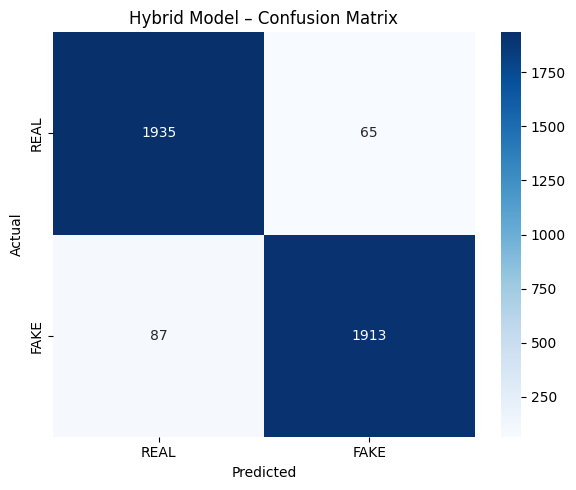

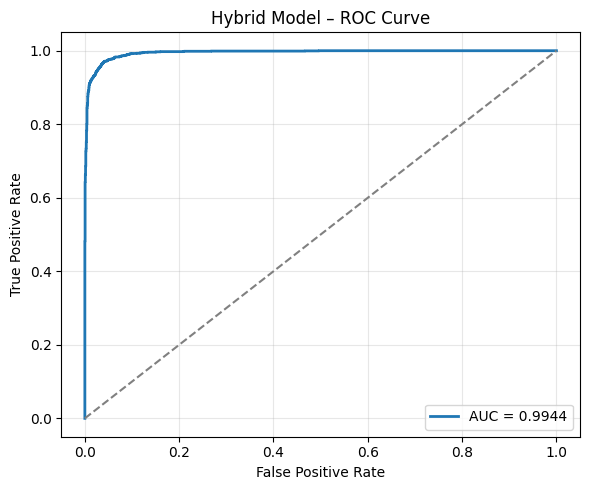


🎉 CM ve ROC başarıyla oluşturuldu!


In [ ]:
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# =====================================================
# 1) VERİLERİ YÜKLE
# =====================================================
X = np.load("X_train_convnext.npy")
y = np.load("y_train.npy")

print("Veriler yüklendi:", X.shape, y.shape)

# =====================================================
# 2) SADECE 1 KEZ EĞİT — %20 VALIDATION
# =====================================================
X_train, X_val, y_train_split, y_val = train_test_split(
    X, y, test_size=0.20, shuffle=True, random_state=42, stratify=y
)

svm = make_pipeline(
    StandardScaler(),
    SVC(C=5.0, kernel="rbf", gamma="scale", probability=True)
)

svm.fit(X_train, y_train_split)

y_pred  = svm.predict(X_val)
y_score = svm.predict_proba(X_val)[:, 1]

# =====================================================
# 3) CONFUSION MATRIX
# =====================================================
cm = confusion_matrix(y_val, y_pred)
print("\nConfusion Matrix:\n", cm)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["REAL", "FAKE"],
            yticklabels=["REAL", "FAKE"])
plt.title("Hybrid Model – Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig("hybrid_confusion_matrix_single.png", dpi=300)
plt.show()

# =====================================================
# 4) ROC CURVE
# =====================================================
fpr, tpr, _ = roc_curve(y_val, y_score)
auc_value = roc_auc_score(y_val, y_score)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc_value:.4f}", linewidth=2)
plt.plot([0,1],[0,1],"--", color="gray")
plt.title("Hybrid Model – ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("hybrid_roc_curve_single.png", dpi=300)
plt.show()

print("\n🎉 CM ve ROC başarıyla oluşturuldu!")
